In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [4]:
df_nisk = pd.read_csv('../Dissertation_projects/Data/CTD/NISK_SUMS.csv', sep=',', index_col=0)

# drop rows with NaN index values
df_nisk = df_nisk[df_nisk['Sample_ID'].notna()]
df_nisk['code'] = df_nisk['station'] + '_' + df_nisk['camp']

# reformat the index to be a whole number
df_nisk.index = df_nisk.index.astype(int)

In [5]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

df_meta

Date     Trip Station  Lat  Lon  Water_depth Sample_depth  \
Sample                                                                    
214371  2021-10-25  GOM21FA   St.5B  NaN  NaN          NaN          NaN   
214671  2021-10-27  GOM21FA   St.MK  NaN  NaN          NaN            2   
214672  2021-10-27  GOM21FA   St.MK  NaN  NaN          NaN            4   
214673  2021-10-27  GOM21FA   St.MK  NaN  NaN          NaN            6   
214674  2021-10-27  GOM21FA   St.MK  NaN  NaN          NaN            8   
...            ...      ...     ...  ...  ...          ...          ...   
225354  2022-07-24  GOM22SU   St.MK  NaN  NaN          NaN          NA    
225355  2022-07-24  GOM22SU   St.MK  NaN  NaN          NaN          NA    
225356  2022-07-24  GOM22SU   St.MK  NaN  NaN          NaN          NA    
225357  2022-07-24  GOM22SU   St.MK  NaN  NaN          NaN          NA    
225358  2022-07-24  GOM22SU   St.MK  NaN  NaN          NaN          NA    

       Sample_depth_units  Wavguide_Path_lengths    BC_time  \
Sample                                                        
214371                 CM                  0.010        NaN   
214671                 CM                  0.010        NaN   
214672                 CM                  0.010        NaN   
214673                 CM                  0.010        NaN   
214674                 CM                  0.010        NaN   
...                   ...                    ...        ...   
225354                  M                  0.489  10.166667   
225355                  M                  0.489  10.933333   
225356                  M                  0.489  11.700000   
225357                  M                  0.489  12.466667   
225358                  M                  0.489  13.233333   

        BC_Chamber_vol_(L)     Type Waveguide_used Notes Flagged   Salinity  \
Sample                                                                        
214371                 NaN      RHZ        1CM CUV   NaN     NaN  31.846576   
214671                 NaN      RHZ        1CM CUV   NaN     NaN  31.447235   
214672                 NaN      RHZ        1CM CUV   NaN     NaN  31.447235   
214673                 NaN      RHZ        1CM CUV   NaN     NaN  31.447235   
214674                 NaN      RHZ        1CM CUV   NaN     NaN  31.447235   
...                    ...      ...            ...   ...     ...        ...   
225354            0.053721  LANDSYR  LWCC 50 CM #2  BC14     NaN  36.007597   
225355            0.053721  LANDSYR  LWCC 50 CM #2  BC15     NaN  36.007597   
225356            0.053721  LANDSYR  LWCC 50 CM #2  BC16     NaN  36.007597   
225357            0.053721  LANDSYR  LWCC 50 CM #2  BC17     NaN  36.007597   
225358            0.053721  LANDSYR  LWCC 50 CM #2  BC18     NaN  36.007597   

        date_time           code  
Sample                            
214371 2021-10-25  St.5B_GOM21FA  
214671 2021-10-27  St.MK_GOM21FA  
214672 2021-10-27  St.MK_GOM21FA  
214673 2021-10-27  St.MK_GOM21FA  
214674 2021-10-27  St.MK_GOM21FA  
...           ...            ...  
225354 2022-07-24  St.MK_GOM22SU  
225355 2022-07-24  St.MK_GOM22SU  
225356 2022-07-24  St.MK_GOM22SU  
225357 2022-07-24  St.MK_GOM22SU  
225358 2022-07-24  St.MK_GOM22SU  

[2515 rows x 18 columns]

In [6]:
df_c = pd.read_csv('../Dissertation_projects/Data/CDOM/Outputs.csv', sep=',', index_col=0)

df_c['Sample_idx'] = df_c.index.astype(object)
df_meta['Sample_idx'] = df_meta.index.astype(object)

df_c.index = df_c['file_id']

df_cdom = df_c.merge(df_meta, on="Sample_idx", how="left")

df_cdom.index = df_cdom['Sample_idx']
df_cdom['Sample'] = df_cdom.index
df_cdom.index = df_cdom['Sample']
df_cdom = df_cdom.drop('Sample_idx', axis = 1)
df_meta = df_meta.drop('Sample_idx', axis = 1)

df_cdom

ss_275_700_sem  ss_275_295_sem  ss_350_400_sem  R2_275_700_sem  \
Sample                                                                   
211901        0.024250        0.015656        0.026895        0.994926   
211902        0.023682        0.016434        0.027076        0.993961   
211902        0.024554        0.021565        0.030541        0.989332   
211903        0.024799        0.011829        0.027034        0.995984   
211904        0.022008        0.007168        0.021896        0.998638   
...                ...             ...             ...             ...   
225364        0.014319        0.004632        0.010942        0.998577   
225364        0.014596        0.004774        0.011522        0.998599   
225365        0.017553        0.005233        0.015880        0.996618   
225365        0.017875        0.000026        0.016640        0.996889   
225365        0.018173        0.001182        0.014022        0.997035   

        R2_275_295_sem  R2_350_400_sem    SR_sem  ss_275_700_hm  \
Sample                                                            
211901        0.998226        0.964339  0.582120       7.253006   
211902        0.998077        0.966006  0.606982       7.089678   
211902        0.993551        0.900661  0.706108            NaN   
211903        0.998714        0.976966  0.437553       7.419606   
211904        0.999015        0.992725  0.327371       6.578661   
...                ...             ...       ...            ...   
225364        0.996929        0.993625  0.423367       4.474485   
225364        0.996951        0.993927  0.414328       4.562037   
225365        0.996428        0.986806  0.329541       5.480805   
225365        0.997200        0.987021  0.001537       5.579656   
225365        0.996244        0.986735  0.084303       5.671222   

        ss_275_295_hm  ss_350_400_hm  ...  BC_time  BC_Chamber_vol_(L)  Type  \
Sample                                ...                                      
211901       3.453476      -0.001138  ...      NaN                 NaN  NISK   
211902       3.671402      -0.001182  ...      NaN                 NaN  NISK   
211902            NaN            NaN  ...      NaN                 NaN  NISK   
211903       2.365078      -0.000872  ...      NaN                 NaN  NISK   
211904       1.036979       7.150482  ...      NaN                 NaN  NISK   
...               ...            ...  ...      ...                 ...   ...   
225364       0.324739       3.077208  ...      NaN                 NaN   RHZ   
225364       0.365645       3.293136  ...      NaN                 NaN   RHZ   
225365       0.490688       4.915428  ...      NaN                 NaN   RHZ   
225365       0.005370       5.194968  ...      NaN                 NaN   RHZ   
225365       0.011001       4.226175  ...      NaN                 NaN   RHZ   

        Waveguide_used  Notes  Flagged   Salinity  date_time           code  \
Sample                                                                        
211901             NaN    NaN      NaN  35.223851 2021-07-15  St.MK_GOM2021   
211902             NaN    NaN      NaN  35.183855 2021-07-15  St.MK_GOM2021   
211902             NaN    NaN      NaN  35.183855 2021-07-15  St.MK_GOM2021   
211903             NaN    NaN      NaN  34.505918 2021-07-15  St.MK_GOM2021   
211904             NaN    NaN      NaN  34.486418 2021-07-15  St.MK_GOM2021   
...                ...    ...      ...        ...        ...            ...   
225364         1CM CUV    NaN      NaN  36.007597 2022-07-23  St.MK_GOM22SU   
225364         1CM CUV    NaN      NaN  36.007597 2022-07-23  St.MK_GOM22SU   
225365         1CM CUV    NaN      NaN  36.007597 2022-07-23  St.MK_GOM22SU   
225365         1CM CUV    NaN      NaN  36.007597 2022-07-23  St.MK_GOM22SU   
225365         1CM CUV    NaN      NaN  36.007597 2022-07-23  St.MK_GOM22SU   

        Sample  
Sample          
211901  211901  
211902  211902  
211902  211902  
211903  211903  
21

In [7]:
#get BC data sets 
df_cdom_bc = df_cdom[df_cdom['Type'] == 'LANDSYR']
df_iron_bc = df_iron[df_iron['Type'] == 'BC']
df_doc_bc = df_doc[df_doc['Type'] == 'BC']

#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get WC data sets 
df_cdom_wc = df_cdom[df_cdom['Type'] == 'NISK']
df_iron_wc = df_iron[df_iron['Type'] == 'WC']
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

In [8]:
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

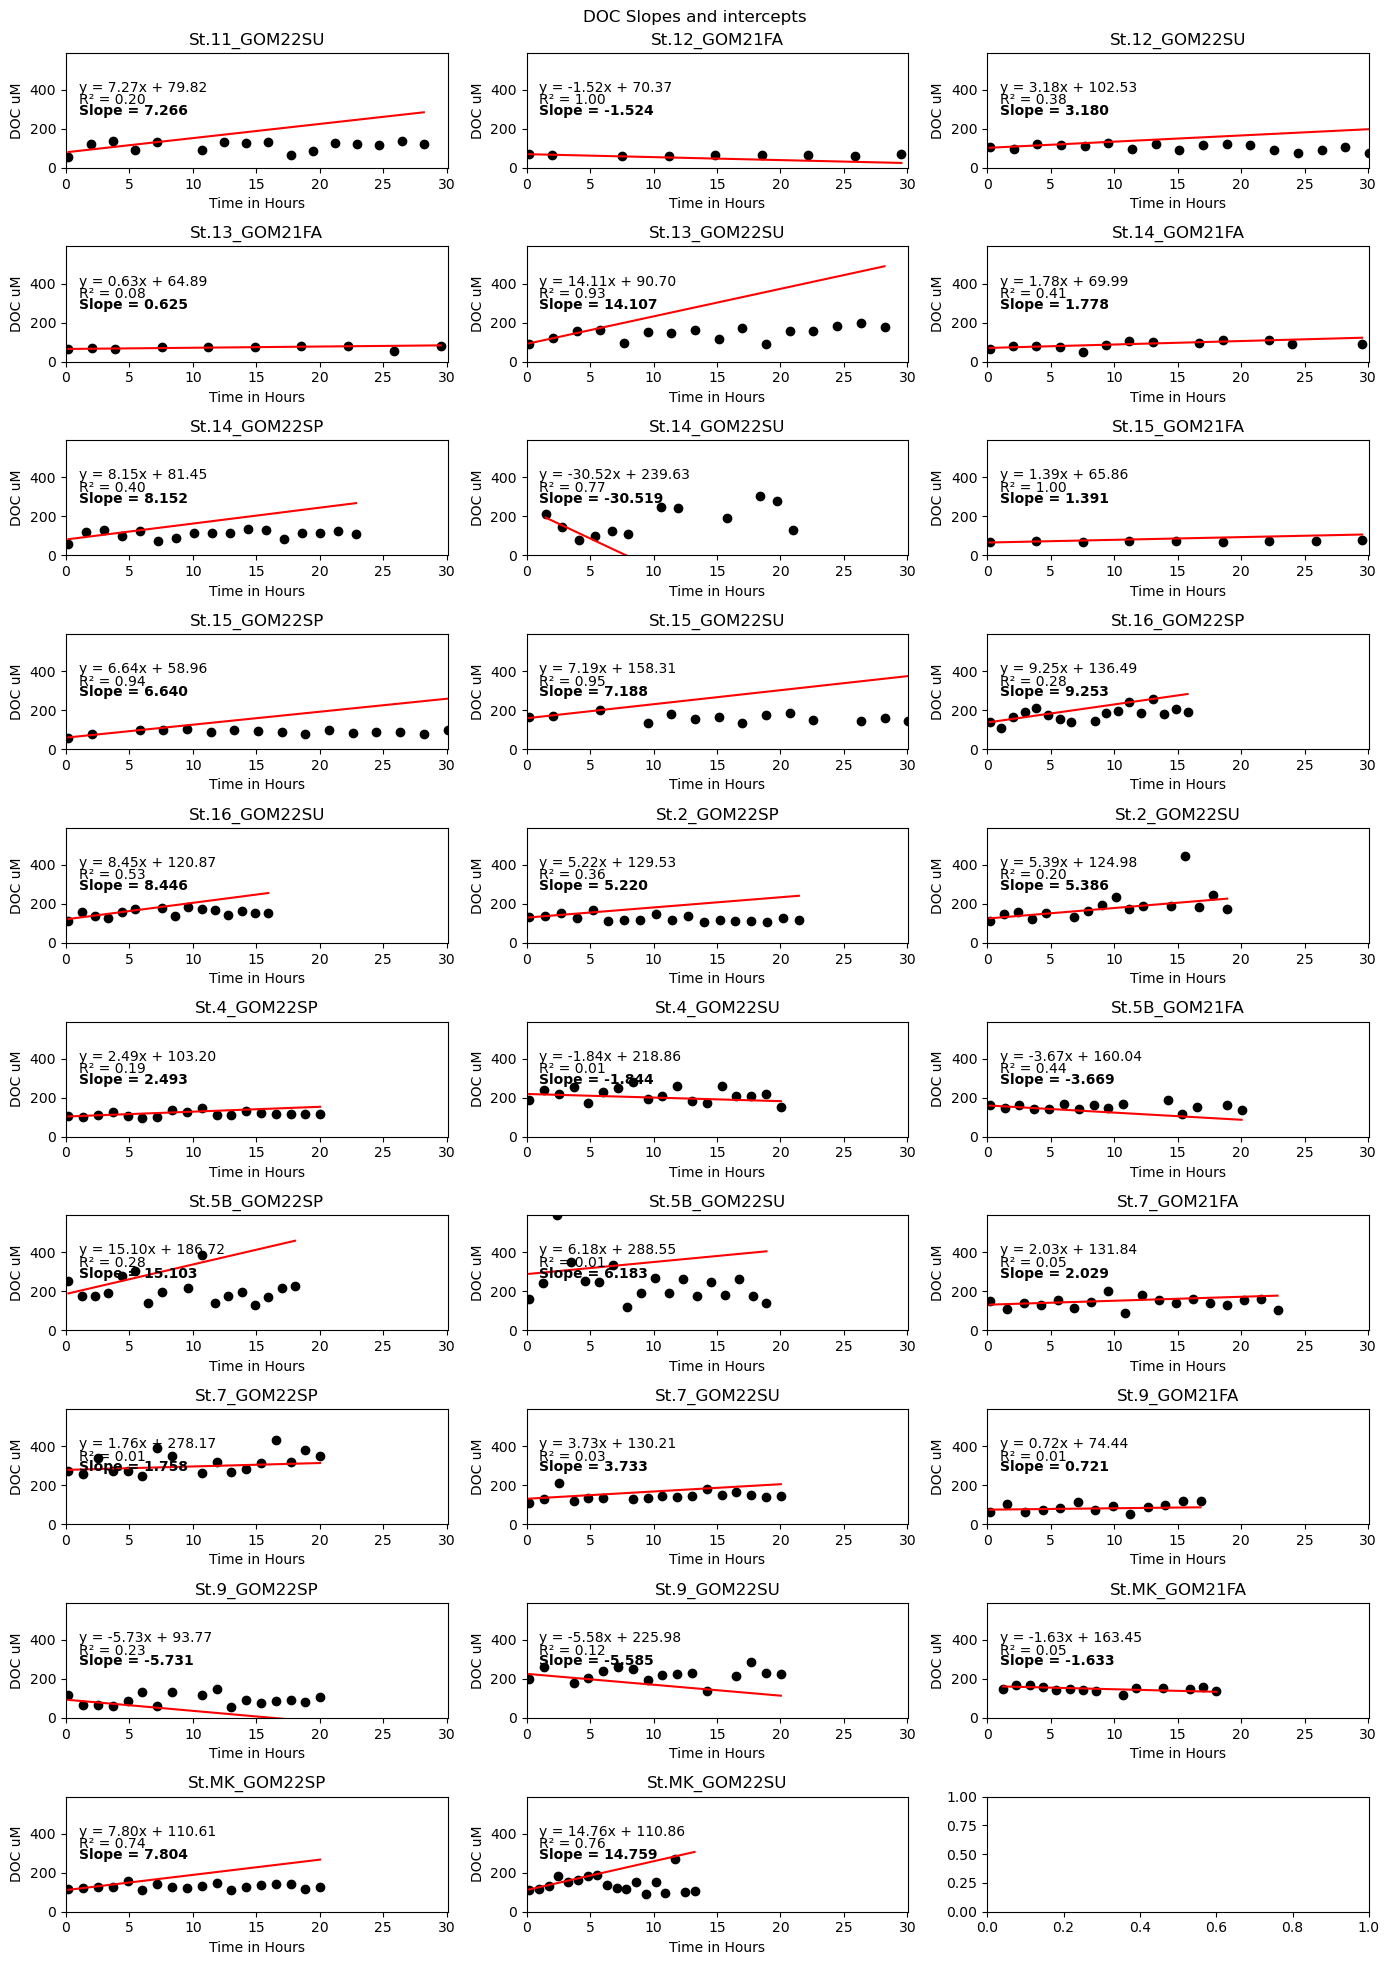

In [9]:
#DOC slopes 
df_doc_bc_plot = df_doc_bc[(df_doc_bc['NPOC_uM'] != 0)]
df_doc_bc_plot = df_doc_bc_plot.dropna(subset=["NPOC_uM"])
codes = df_doc_bc_plot['code'].unique()
df_doc_bc_plot = df_doc_bc_plot[df_doc_bc_plot['code'] != 'St.13_GOM22SP']

#make plot
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(14, 20)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['Time']
    y = group['NPOC_uM']
    
    xx = group.loc[group['Time'] < 6, 'Time'].ravel()
    yy = group.loc[group['Time'] < 6, 'NPOC_uM'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c="black")
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time in Hours')
    ax.set_ylabel('DOC uM')
    ax.set_xlim(0,df_doc_bc['Time'].max())
    ax.set_ylim(df_doc_bc['NPOC_uM'].min(),df_doc_bc['NPOC_uM'].max())
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='r')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, 390, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, 325, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, 270, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'DOC Slopes and intercepts' '\n')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/DOC_flux.png")

plt.show()


In [10]:
#DOC slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group.loc[group['Time'] < 6, 'Time'].ravel()
    y = group.loc[group['Time'] < 6, 'NPOC_uM'].ravel()
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_doc':[slope],
            'rsquared_doc':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_doc = pd.concat(Frames, axis=0, ignore_index=False)
slopes_doc

slope_doc  rsquared_doc
code                                  
St.11_GOM22SU   7.265918      0.204340
St.12_GOM21FA  -1.524091      1.000000
St.12_GOM22SU   3.180166      0.379881
St.13_GOM21FA   0.625000      0.084778
St.13_GOM22SU  14.107143      0.926323
St.14_GOM21FA   1.777518      0.409972
St.14_GOM22SP   8.152290      0.403972
St.14_GOM22SU -30.518933      0.774137
St.15_GOM21FA   1.390909      1.000000
St.15_GOM22SP   6.639828      0.940474
St.15_GOM22SU   7.188008      0.949981
St.16_GOM22SP   9.253247      0.283803
St.16_GOM22SU   8.446195      0.530843
St.2_GOM22SP    5.220000      0.364585
St.2_GOM22SU    5.385781      0.200625
St.4_GOM22SP    2.492857      0.193595
St.4_GOM22SU   -1.843750      0.009835
St.5B_GOM21FA  -3.669481      0.439641
St.5B_GOM22SP  15.103369      0.281482
St.5B_GOM22SU   6.182630      0.007059
St.7_GOM21FA    2.028551      0.049894
St.7_GOM22SP    1.758401      0.009880
St.7_GOM22SU    3.733310      0.027966
St.9_GOM21FA    0.721496      0.008417
St.9_GOM22SP   -5.731071      0.225371
St.9_GOM22SU   -5.584821      0.124641
St.MK_GOM21FA  -1.633389      0.049326
St.MK_GOM22SP   7.803571      0.740511
St.MK_GOM22SU  14.759317      0.756148

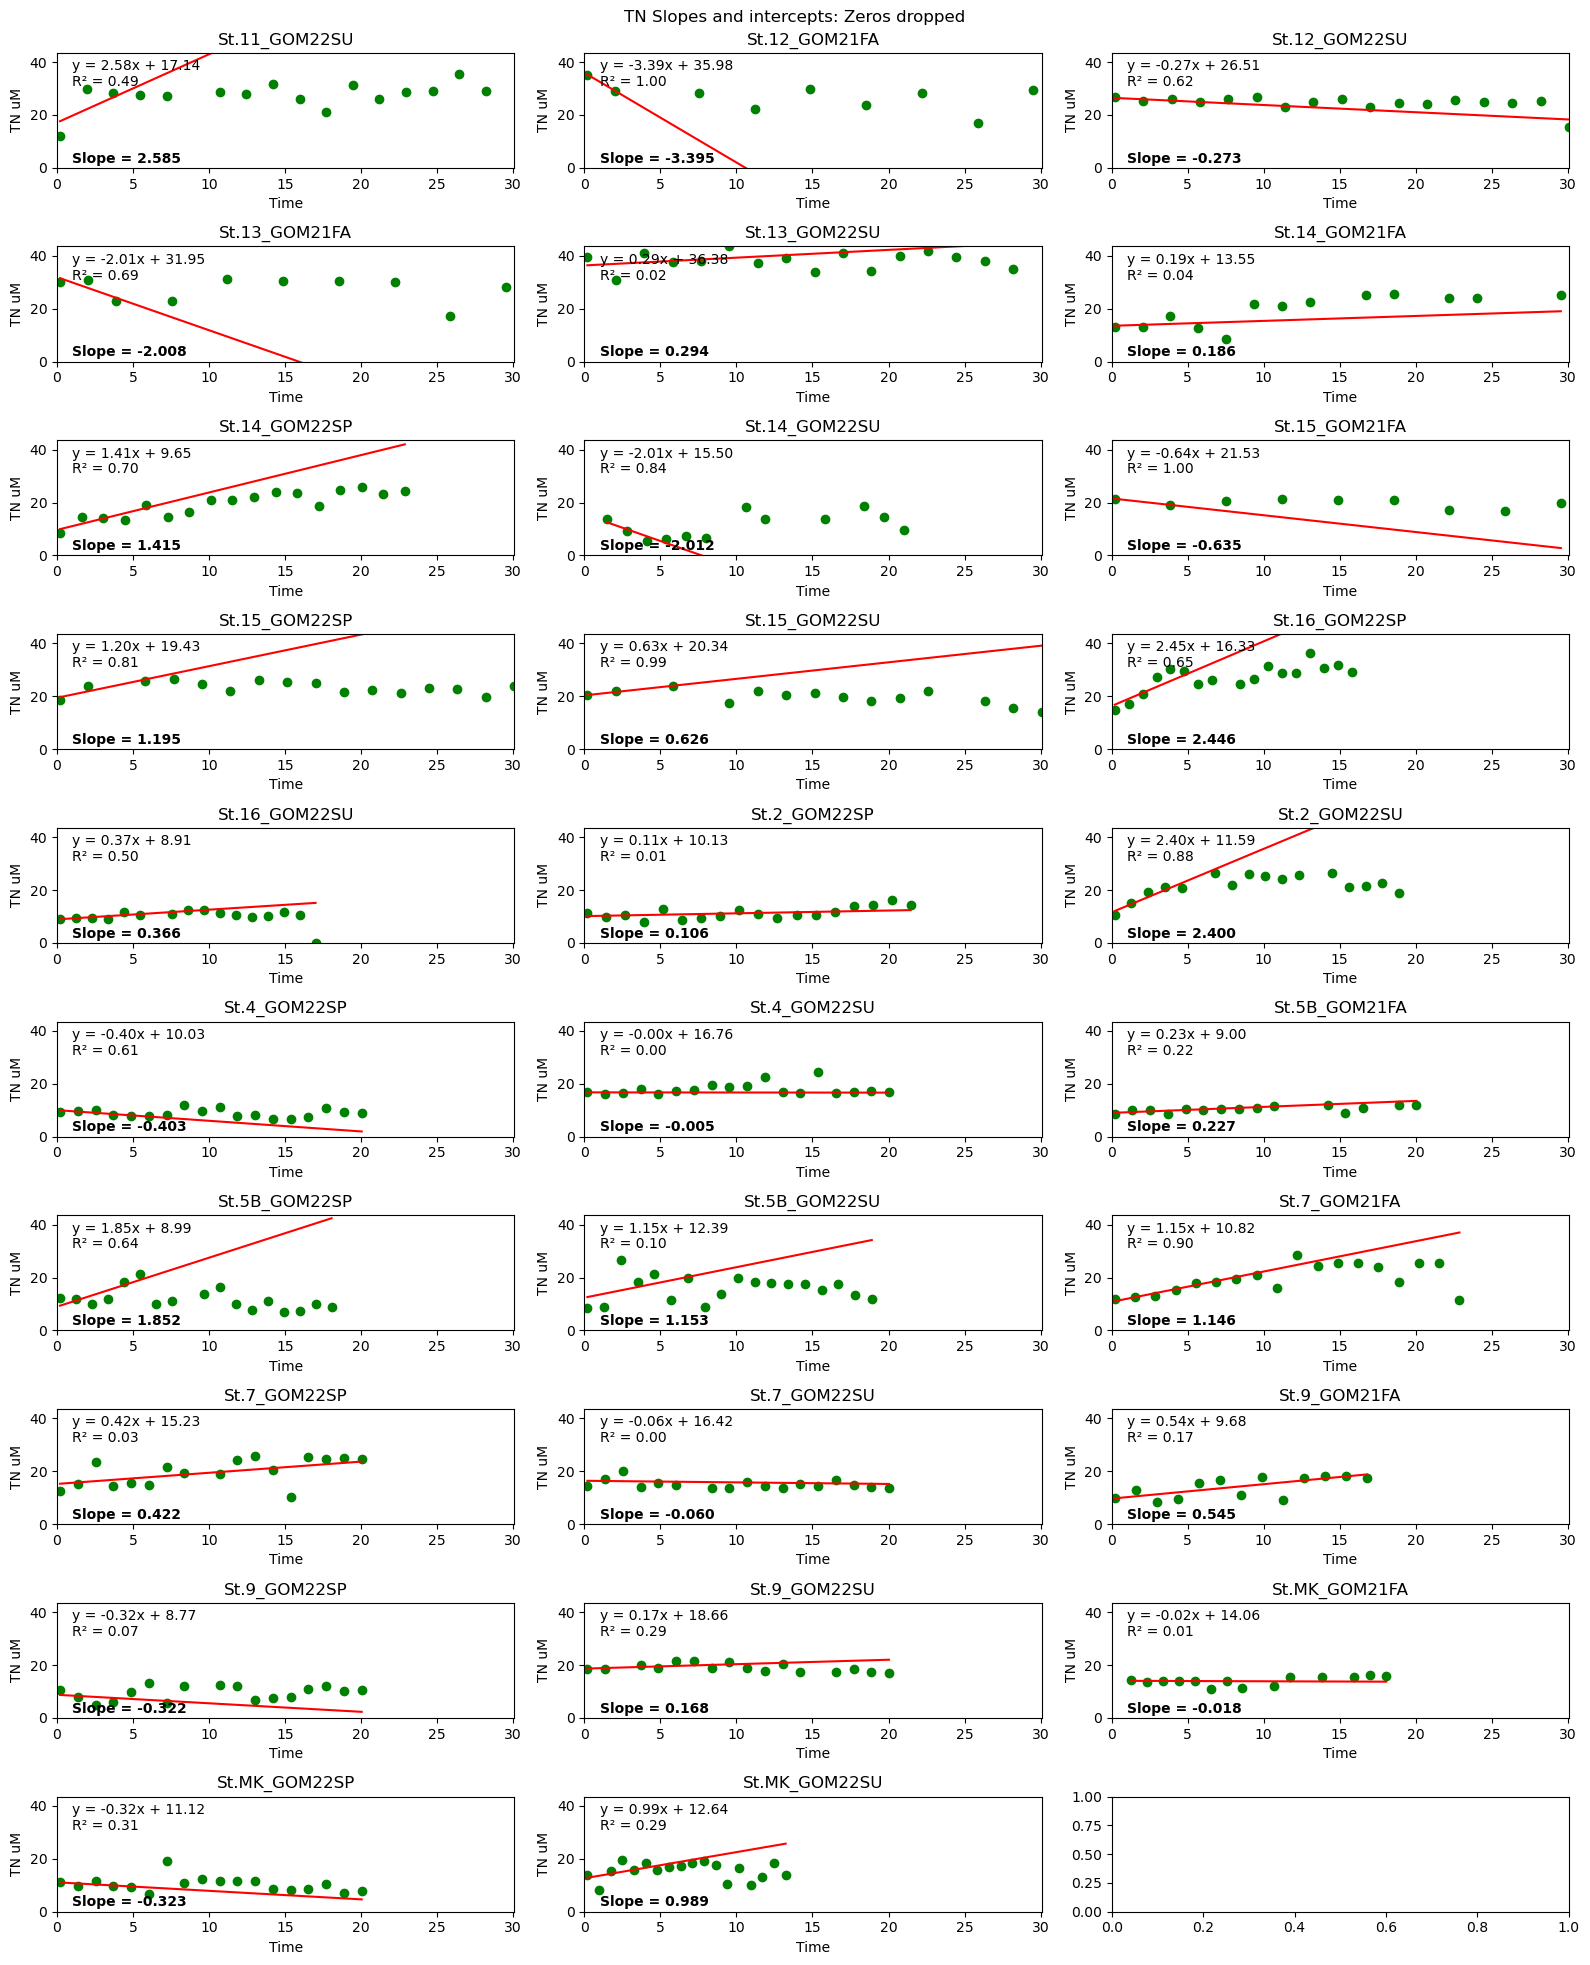

In [11]:
#Nitrogen slopes

fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(16, 20)) 

df_tn_bc_plot = df_doc_bc[(df_doc_bc['TN_uM'] != 0)]
df_tn_bc_plot = df_tn_bc_plot.dropna(subset=["TN_uM"])
codes = df_tn_bc_plot['code'].unique()
df_tn_bc_plot = df_tn_bc_plot[df_tn_bc_plot['code'] != 'St.13_GOM22SP']

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_tn_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['Time'].ravel()
    y = group['TN_uM'].ravel()  

    
    xx = group.loc[group['Time'] < 6, 'Time'].ravel()
    yy = group.loc[group['Time'] < 6, 'TN_uM'].ravel()    
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='green')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('TN uM')
    ax.set_xlim(0,df_doc_bc['Time'].max())
    ax.set_ylim(df_doc_bc['TN_uM'].min(),df_doc_bc['TN_uM'].max())
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='red')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, 37, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, 31, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, 2, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'TN Slopes and intercepts: Zeros dropped' '\n')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/TN_flux.png")

plt.show()


In [12]:
#TN slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_tn_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group.loc[group['Time'] < 6, 'Time'].ravel()
    y = group.loc[group['Time'] < 6, 'TN_uM'].ravel()
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_tn':[slope],
            'rsquared_tn':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_tn = pd.concat(Frames, axis=0, ignore_index=False)
slopes_tn

slope_tn  rsquared_tn
code                                
St.11_GOM22SU  2.584606     0.488047
St.12_GOM21FA -3.394675     1.000000
St.12_GOM22SU -0.273078     0.620832
St.13_GOM21FA -2.008442     0.694634
St.13_GOM22SU  0.294196     0.023826
St.14_GOM21FA  0.186449     0.038779
St.14_GOM22SP  1.414574     0.704038
St.14_GOM22SU -2.011802     0.836732
St.15_GOM21FA -0.635065     1.000000
St.15_GOM22SP  1.195381     0.810109
St.15_GOM22SU  0.625699     0.992283
St.16_GOM22SP  2.445779     0.651581
St.16_GOM22SU  0.366471     0.503228
St.2_GOM22SP   0.106000     0.013189
St.2_GOM22SU   2.400125     0.880276
St.4_GOM22SP  -0.402551     0.609384
St.4_GOM22SU  -0.004974     0.000163
St.5B_GOM21FA  0.226642     0.216094
St.5B_GOM22SP  1.852331     0.637674
St.5B_GOM22SU  1.153128     0.102364
St.7_GOM21FA   1.146246     0.896084
St.7_GOM22SP   0.421591     0.033136
St.7_GOM22SU  -0.059935     0.002073
St.9_GOM21FA   0.544755     0.170334
St.9_GOM22SP  -0.321980     0.065539
St.9_GOM22SU   0.167857     0.285350
St.MK_GOM21FA -0.018486     0.009225
St.MK_GOM22SP -0.322653     0.312777
St.MK_GOM22SU  0.989493     0.293646

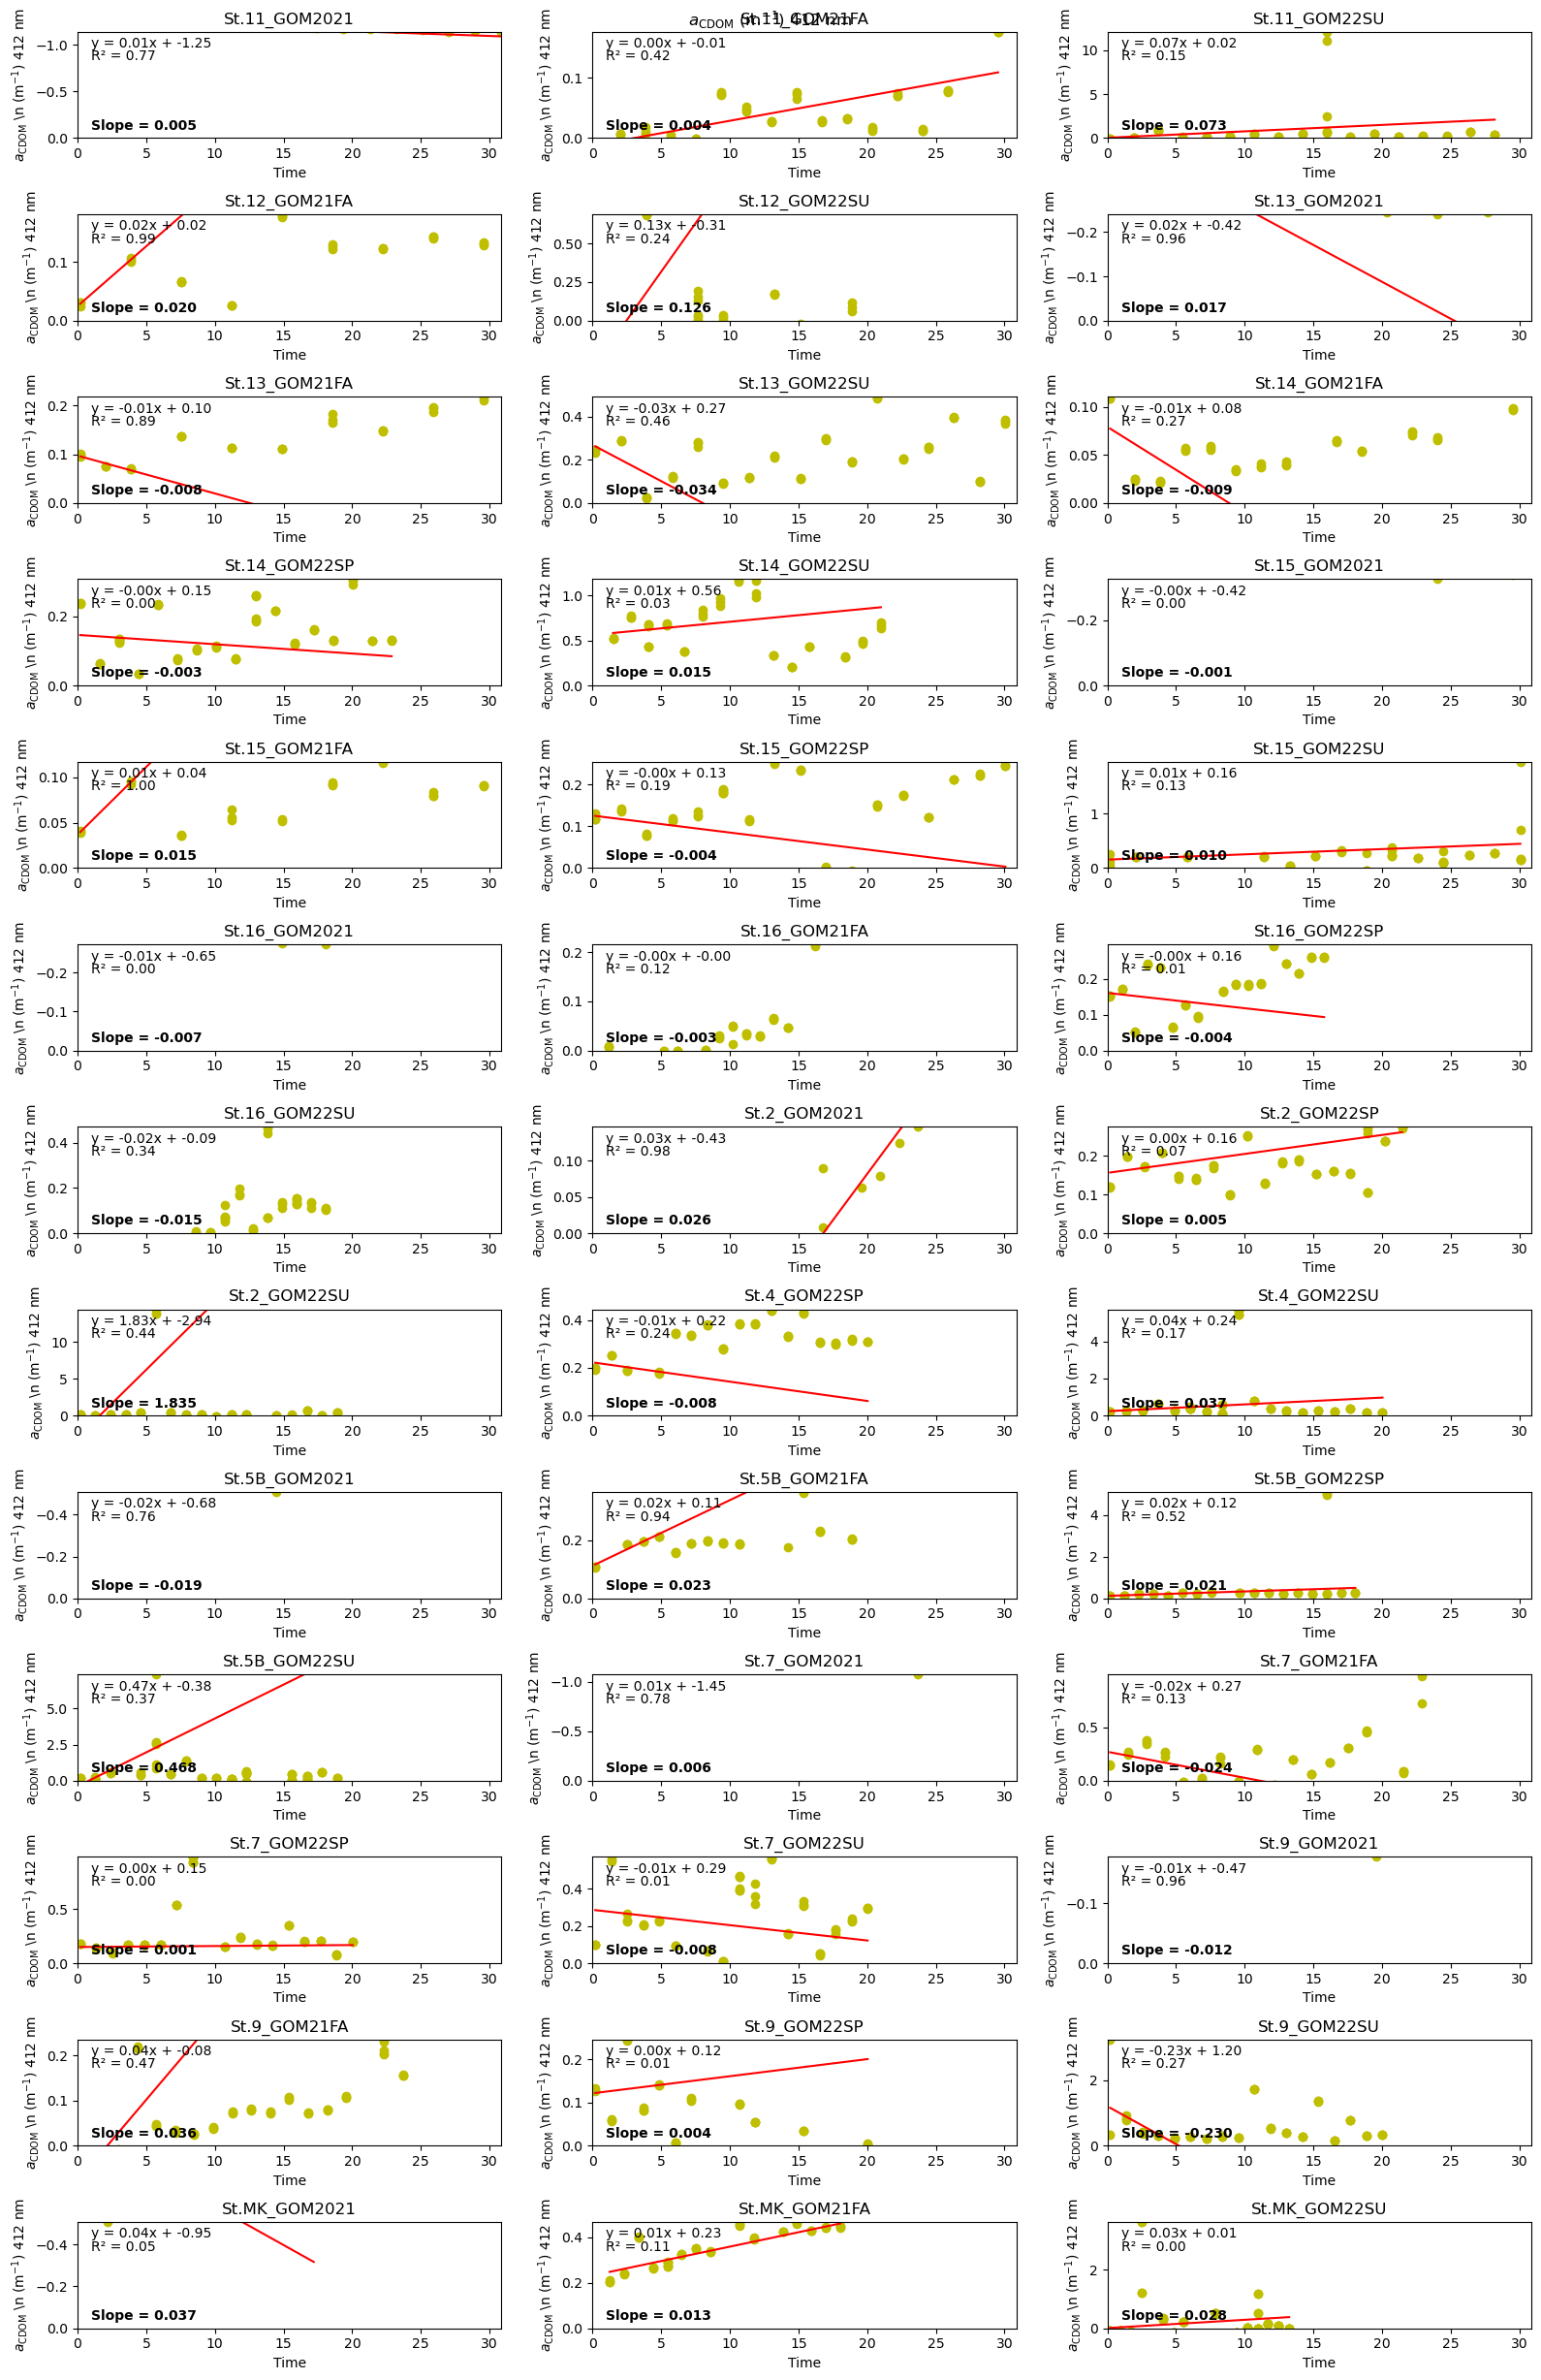

In [13]:
#CDOM slopes

df_cdom_bc_plot = df_cdom_bc[df_cdom_bc['code'] != 'St.13_GOM22SP']
df_cdom_bc_plot = df_cdom_bc_plot[df_cdom_bc_plot['code'] != 'St.14_GOM2021']
df_cdom_bc_plot = df_cdom_bc_plot.dropna(subset=['acdom_412_bc'])
codes = df_cdom_bc_plot['code'].unique()

fig, axs = plt.subplots(nrows=13, ncols=3, figsize=(16, 25)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['BC_time'].ravel()
    y = group['acdom_412_bc'].ravel()
    
    xx = group.loc[group['BC_time'] <6 , 'BC_time'].ravel()
    yy = group.loc[group['BC_time'] <6, 'acdom_412_bc'].ravel()

    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='y')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$a_{\mathrm{CDOM}}$ \n (m$^{-1}$) 412 nm')
    ax.set_xlim(0,df_cdom_bc['BC_time'].max())
    ax.set_ylim(0,max(y))
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='r')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, max(y)*.85, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, max(y)*.73, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, max(y)*.08, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'$a_{\mathrm{CDOM}}$ (m$^{-1}$) 412 nm')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM412_flux.png")

plt.show()


In [14]:
#CDOM slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_bc_plot.groupby('code')):
    
    # Extract x, y, and c data from the group
    x = group.loc[group['BC_time'] <6 , 'BC_time'].ravel()
    y = group.loc[group['BC_time'] <6, 'acdom_412_bc'].ravel()
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_a412':[slope],
            'rsquared_a412':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_a412 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_a412

slope_a412  rsquared_a412
code                                    
St.11_GOM2021    0.005215       0.772857
St.11_GOM21FA    0.004109       0.418177
St.11_GOM22SU    0.073135       0.149332
St.12_GOM21FA    0.020387       0.993842
St.12_GOM22SU    0.125514       0.242666
St.13_GOM2021    0.016707       0.964738
St.13_GOM21FA   -0.007752       0.893334
St.13_GOM22SU   -0.033504       0.457170
St.14_GOM21FA   -0.008956       0.269227
St.14_GOM22SP   -0.002697       0.004056
St.14_GOM22SU    0.014624       0.026772
St.15_GOM2021   -0.001049       0.004242
St.15_GOM21FA    0.014926       0.997895
St.15_GOM22SP   -0.004065       0.194422
St.15_GOM22SU    0.009605       0.132571
St.16_GOM2021   -0.006845       0.002323
St.16_GOM21FA   -0.003061       0.120879
St.16_GOM22SP   -0.004262       0.013147
St.16_GOM22SU   -0.015287       0.337639
St.2_GOM2021     0.025588       0.977431
St.2_GOM22SP     0.004888       0.068574
St.2_GOM22SU     1.834835       0.443564
St.4_GOM22SP    -0.008073       0.237319
St.4_GOM22SU     0.036592       0.169019
St.5B_GOM2021   -0.019317       0.764388
St.5B_GOM21FA    0.022647       0.938282
St.5B_GOM22SP    0.021206       0.517922
St.5B_GOM22SU    0.467911       0.367185
St.7_GOM2021     0.005769       0.783978
St.7_GOM21FA    -0.024455       0.129311
St.7_GOM22SP     0.000903       0.002212
St.7_GOM22SU    -0.008227       0.007757
St.9_GOM2021    -0.012174       0.956379
St.9_GOM21FA     0.035855       0.468878
St.9_GOM22SP     0.003948       0.010450
St.9_GOM22SU    -0.230440       0.268969
St.MK_GOM2021    0.036555       0.045046
St.MK_GOM21FA    0.012664       0.108803
St.MK_GOM22SU    0.028309       0.003692

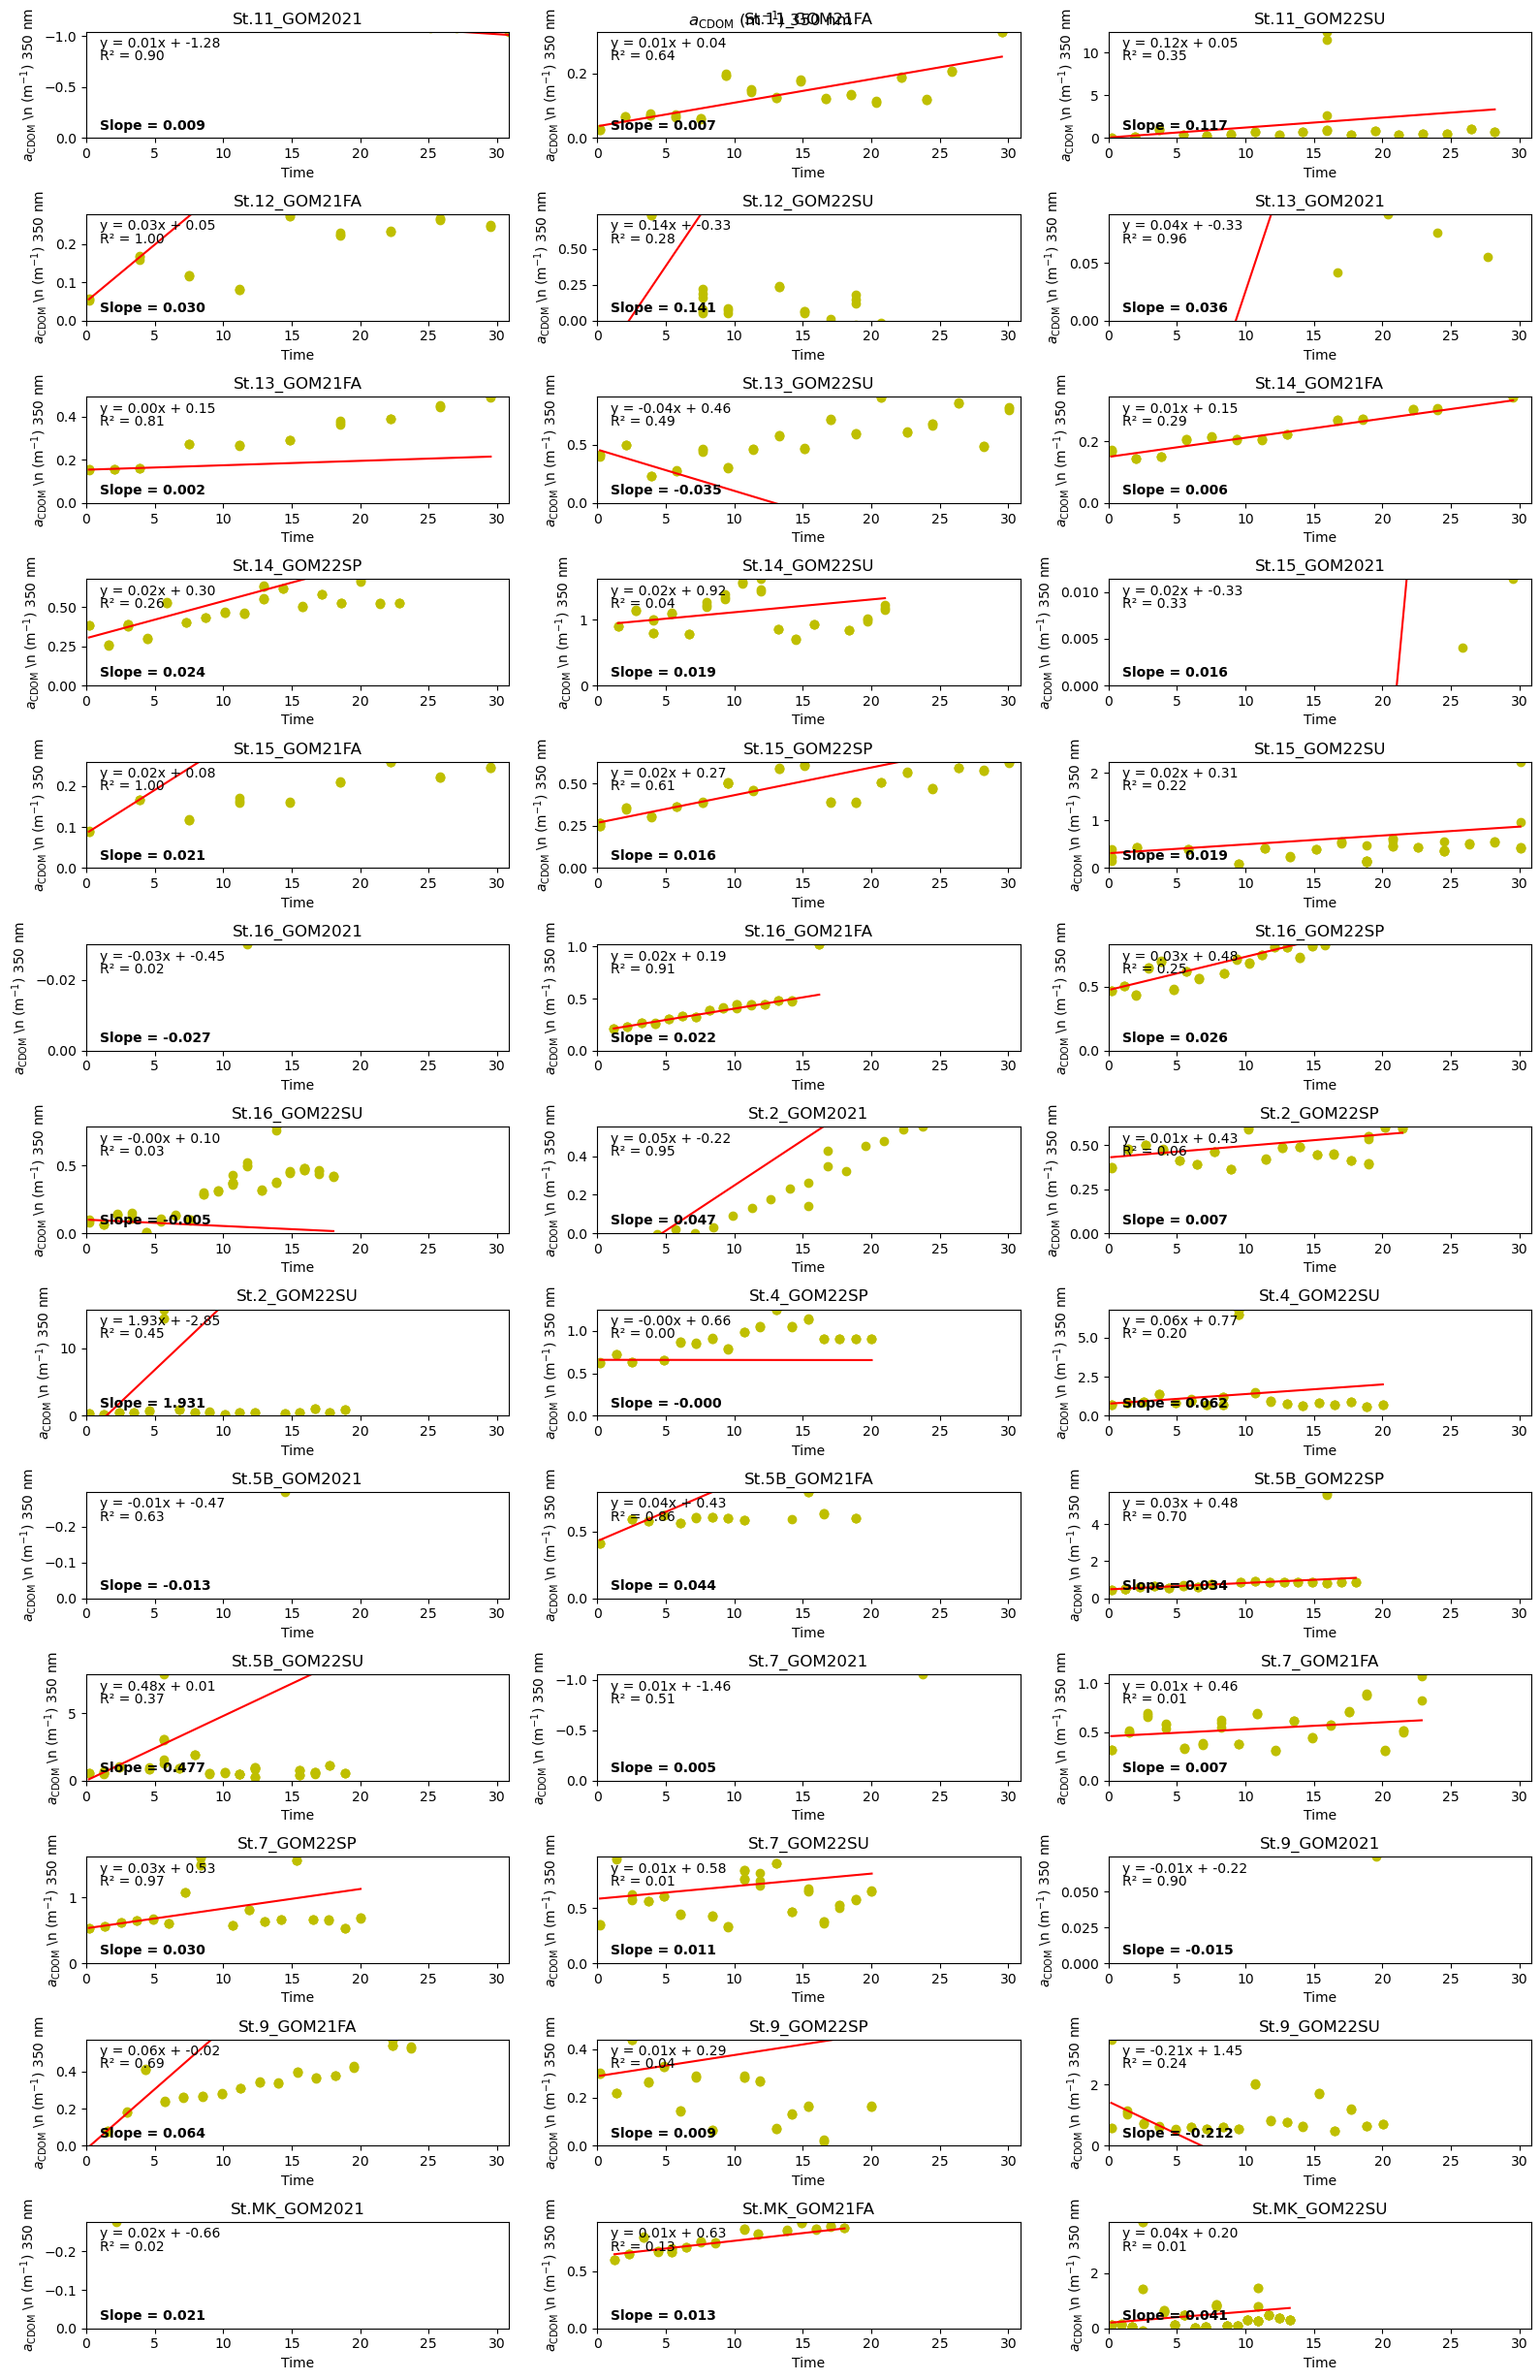

In [15]:
#CDOM slopes

df_cdom_bc_plot = df_cdom_bc[df_cdom_bc['code'] != 'St.13_GOM22SP']
df_cdom_bc_plot = df_cdom_bc_plot[df_cdom_bc_plot['code'] != 'St.14_GOM2021']
df_cdom_bc_plot = df_cdom_bc_plot.dropna(subset=['acdom_412_bc'])

fig, axs = plt.subplots(nrows=13, ncols=3, figsize=(16, 25)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['BC_time'].ravel()
    y = group['acdom_350_bc'].ravel()
    
    xx = group.loc[group['BC_time'] <6 , 'BC_time'].ravel()
    yy = group.loc[group['BC_time'] <6, 'acdom_350_bc'].ravel()

    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='y')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel(r'$a_{\mathrm{CDOM}}$ \n (m$^{-1}$) 350 nm')
    ax.set_xlim(0,df_cdom_bc['BC_time'].max())
    ax.set_ylim(0,max(y))
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='r')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, max(y)*.85, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, max(y)*.73, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, max(y)*.08, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'$a_{\mathrm{CDOM}}$ (m$^{-1}$) 350 nm')
plt.tight_layout()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM350_flux.png")

plt.show()


In [16]:
#CDOM slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_cdom_bc_plot.groupby('code')):
    
    # Extract x, y, and c data from the group
    x = group.loc[group['BC_time'] <6 , 'BC_time'].ravel()
    y = group.loc[group['BC_time'] <6, 'acdom_350_bc'].ravel()
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_a350':[slope],
            'rsquared_a350':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_a350 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_a350

slope_a350  rsquared_a350
code                                    
St.11_GOM2021    0.008768       0.903783
St.11_GOM21FA    0.007327       0.636672
St.11_GOM22SU    0.116666       0.345707
St.12_GOM21FA    0.029835       0.996677
St.12_GOM22SU    0.141037       0.283286
St.13_GOM2021    0.035649       0.962411
St.13_GOM21FA    0.002056       0.807854
St.13_GOM22SU   -0.035450       0.490662
St.14_GOM21FA    0.006195       0.286737
St.14_GOM22SP    0.023659       0.259729
St.14_GOM22SU    0.019390       0.042316
St.15_GOM2021    0.015756       0.332649
St.15_GOM21FA    0.021143       0.999521
St.15_GOM22SP    0.016308       0.612152
St.15_GOM22SU    0.018659       0.216152
St.16_GOM2021   -0.027476       0.024289
St.16_GOM21FA    0.021677       0.912168
St.16_GOM22SP    0.026097       0.251978
St.16_GOM22SU   -0.004682       0.033415
St.2_GOM2021     0.046970       0.946110
St.2_GOM22SP     0.006518       0.058448
St.2_GOM22SU     1.930509       0.449317
St.4_GOM22SP    -0.000138       0.000041
St.4_GOM22SU     0.061811       0.199185
St.5B_GOM2021   -0.012997       0.628461
St.5B_GOM21FA    0.043819       0.857437
St.5B_GOM22SP    0.034374       0.700981
St.5B_GOM22SU    0.477298       0.371053
St.7_GOM2021     0.005495       0.505170
St.7_GOM21FA     0.007160       0.009595
St.7_GOM22SP     0.029961       0.974848
St.7_GOM22SU     0.011398       0.009373
St.9_GOM2021    -0.014563       0.903718
St.9_GOM21FA     0.064324       0.686417
St.9_GOM22SP     0.008755       0.037697
St.9_GOM22SU    -0.212350       0.241059
St.MK_GOM2021    0.021409       0.018535
St.MK_GOM21FA    0.013441       0.126342
St.MK_GOM22SU    0.040569       0.007420

In [17]:
#clean out the Iron data for the slopes 
df_iron_bc_fe2_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe2_uM'] == 0) | (df_iron_bc['Fe2_uM'].isna())].index)

#clean out the Iron data for the slopes 
df_iron_bc_fe3_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe3_uM'] == 0) | (df_iron_bc['Fe3_uM'].isna())].index)

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


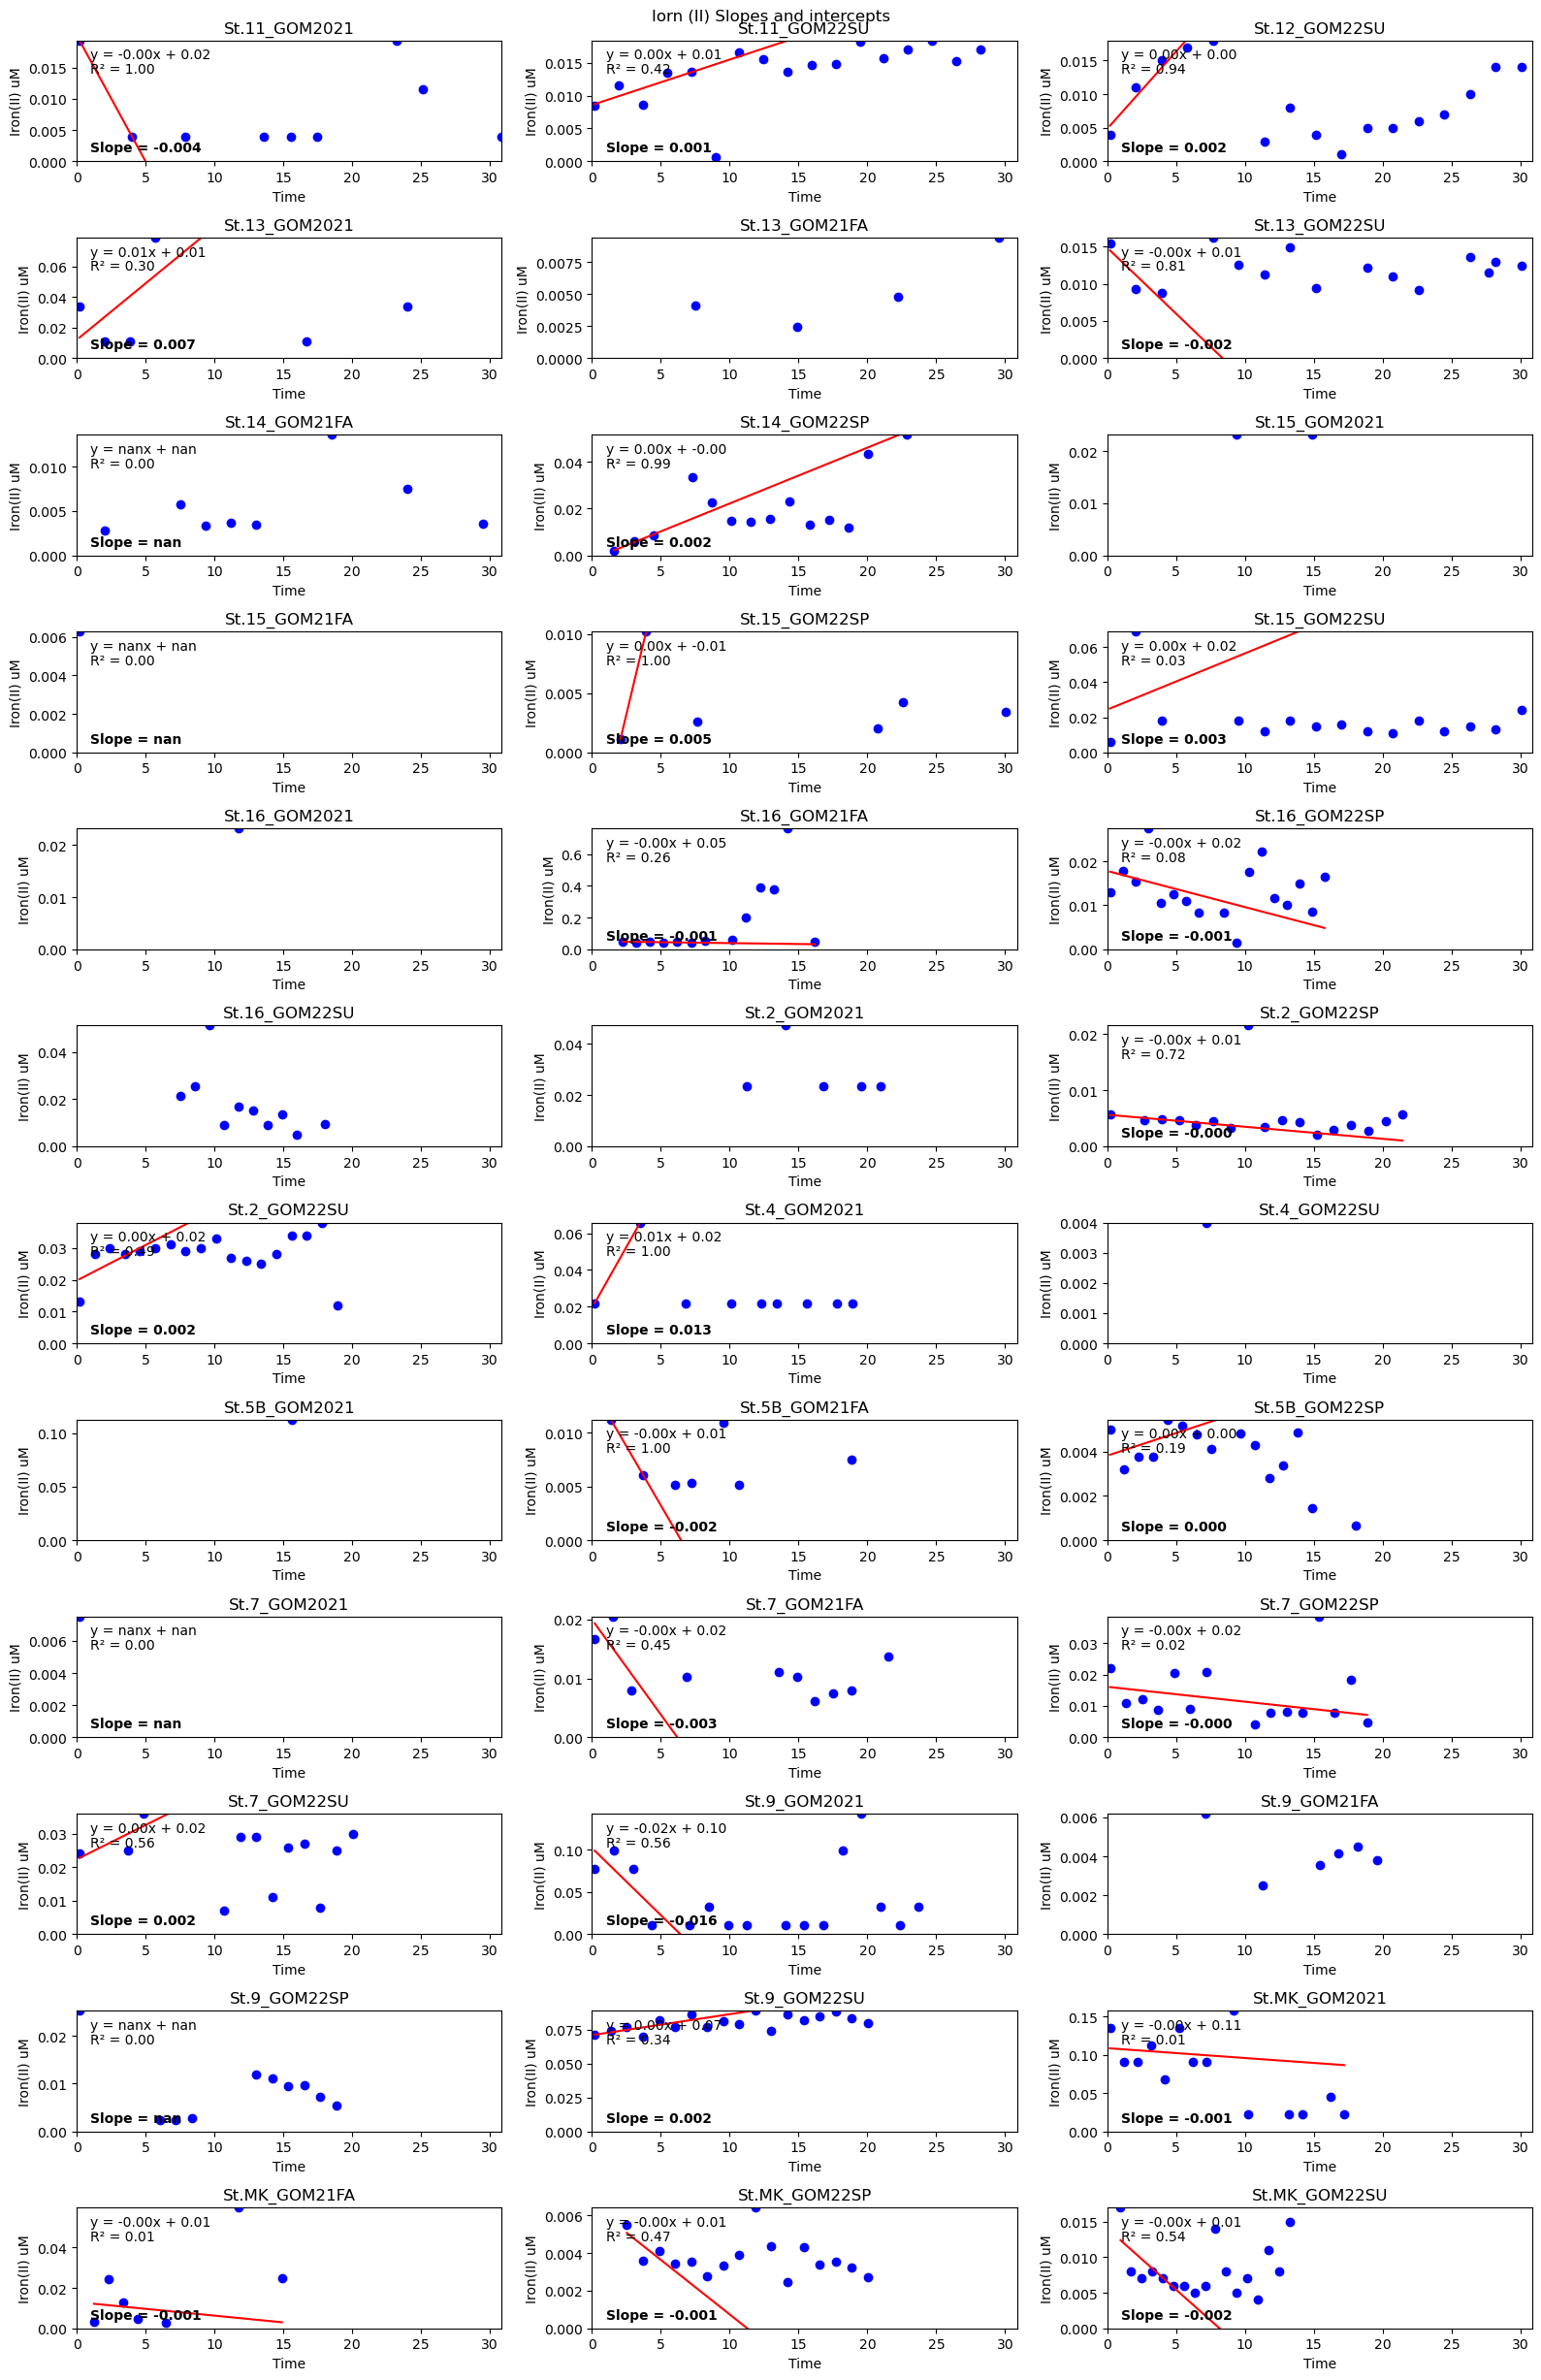

In [18]:
#Iron 2 slopes 

fig, axs = plt.subplots(nrows=12, ncols=3, figsize=(16, 25)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe2_cl.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['Fe2_Time']
    y = group['Fe2_uM']
    
    xx = group.loc[group['Fe2_Time'] <6 , 'Fe2_Time'].ravel()
    yy = group.loc[group['Fe2_Time'] <6, 'Fe2_uM'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='b')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('Iron(II) uM')
    ax.set_xlim(0,df_iron_bc_fe2_cl['Fe2_Time'].max())
    ax.set_ylim(0,max(y))
    
    if len(xx) > 0 and len(yy) > 0:
        # Calculate the slope of the regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
        
        # Add the regression line to the plot
        ax.plot(x, intercept + slope * x, c='r')
    
        # Add the equation of the regression line to the plot
        equation = f'y = {slope:.2f}x + {intercept:.2f}'
        ax.text(1, max(y)*.85, equation)
    
        # Add the r-squared value to the plot
        rsquared = f'R² = {r_value**2:.2f}'
        ax.text(1, max(y)*.73, rsquared)
    
        # Add the slope value to the plot
        sloped = f'Slope = {slope:.3f}'
        ax.text(1, max(y)*.08, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'Iorn (II) Slopes and intercepts' '\n')
plt.tight_layout()
plt.show()


In [19]:
#Fe2 slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe2_cl.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group.loc[group['Fe2_Time'] <6 , 'Fe2_Time'].ravel()
    y = group.loc[group['Fe2_Time'] <6, 'Fe2_uM'].ravel()

    if len(x) > 0 and len(y) > 0:
        # Calculate the slope of the regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        # Add the r-squared value to the plot
        rsquared = r_value**2
    
        # Add the slope value to the plot
        slope = slope
    
        dic = {'code':[code],
               'slope_fe2':[slope],
               'rsquared_fe2':[rsquared]}
    
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_fe2 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_fe2

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\b

slope_fe2  rsquared_fe2
code                                  
St.11_GOM2021  -0.004036      1.000000
St.11_GOM22SU   0.000691      0.415760
St.12_GOM22SU   0.002304      0.936203
St.13_GOM2021   0.007384      0.300000
St.13_GOM2021   0.007384      0.300000
St.13_GOM22SU  -0.001768      0.806468
St.14_GOM21FA        NaN      0.000000
St.14_GOM22SP   0.002387      0.989305
St.14_GOM22SP   0.002387      0.989305
St.15_GOM21FA        NaN      0.000000
St.15_GOM22SP   0.004875      1.000000
St.15_GOM22SU   0.003214      0.032172
St.15_GOM22SU   0.003214      0.032172
St.16_GOM21FA  -0.001140      0.260493
St.16_GOM22SP  -0.000821      0.075855
St.16_GOM22SP  -0.000821      0.075855
St.16_GOM22SP  -0.000821      0.075855
St.2_GOM22SP   -0.000215      0.722328
St.2_GOM22SU    0.002234      0.486152
St.4_GOM2021    0.013294      1.000000
St.4_GOM2021    0.013294      1.000000
St.4_GOM2021    0.013294      1.000000
St.5B_GOM21FA  -0.002198      1.000000
St.5B_GOM22SP   0.000204      0.187148
St.7_GOM2021         NaN      0.000000
St.7_GOM21FA   -0.003221      0.452137
St.7_GOM22SP   -0.000474      0.021643
St.7_GOM22SU    0.002044      0.555813
St.9_GOM2021   -0.015910      0.555556
St.9_GOM2021   -0.015910      0.555556
St.9_GOM22SP         NaN      0.000000
St.9_GOM22SU    0.001543      0.341772
St.MK_GOM2021  -0.001288      0.007792
St.MK_GOM21FA  -0.000670      0.008741
St.MK_GOM22SP  -0.000580      0.474454
St.MK_GOM22SU  -0.001724      0.544984

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


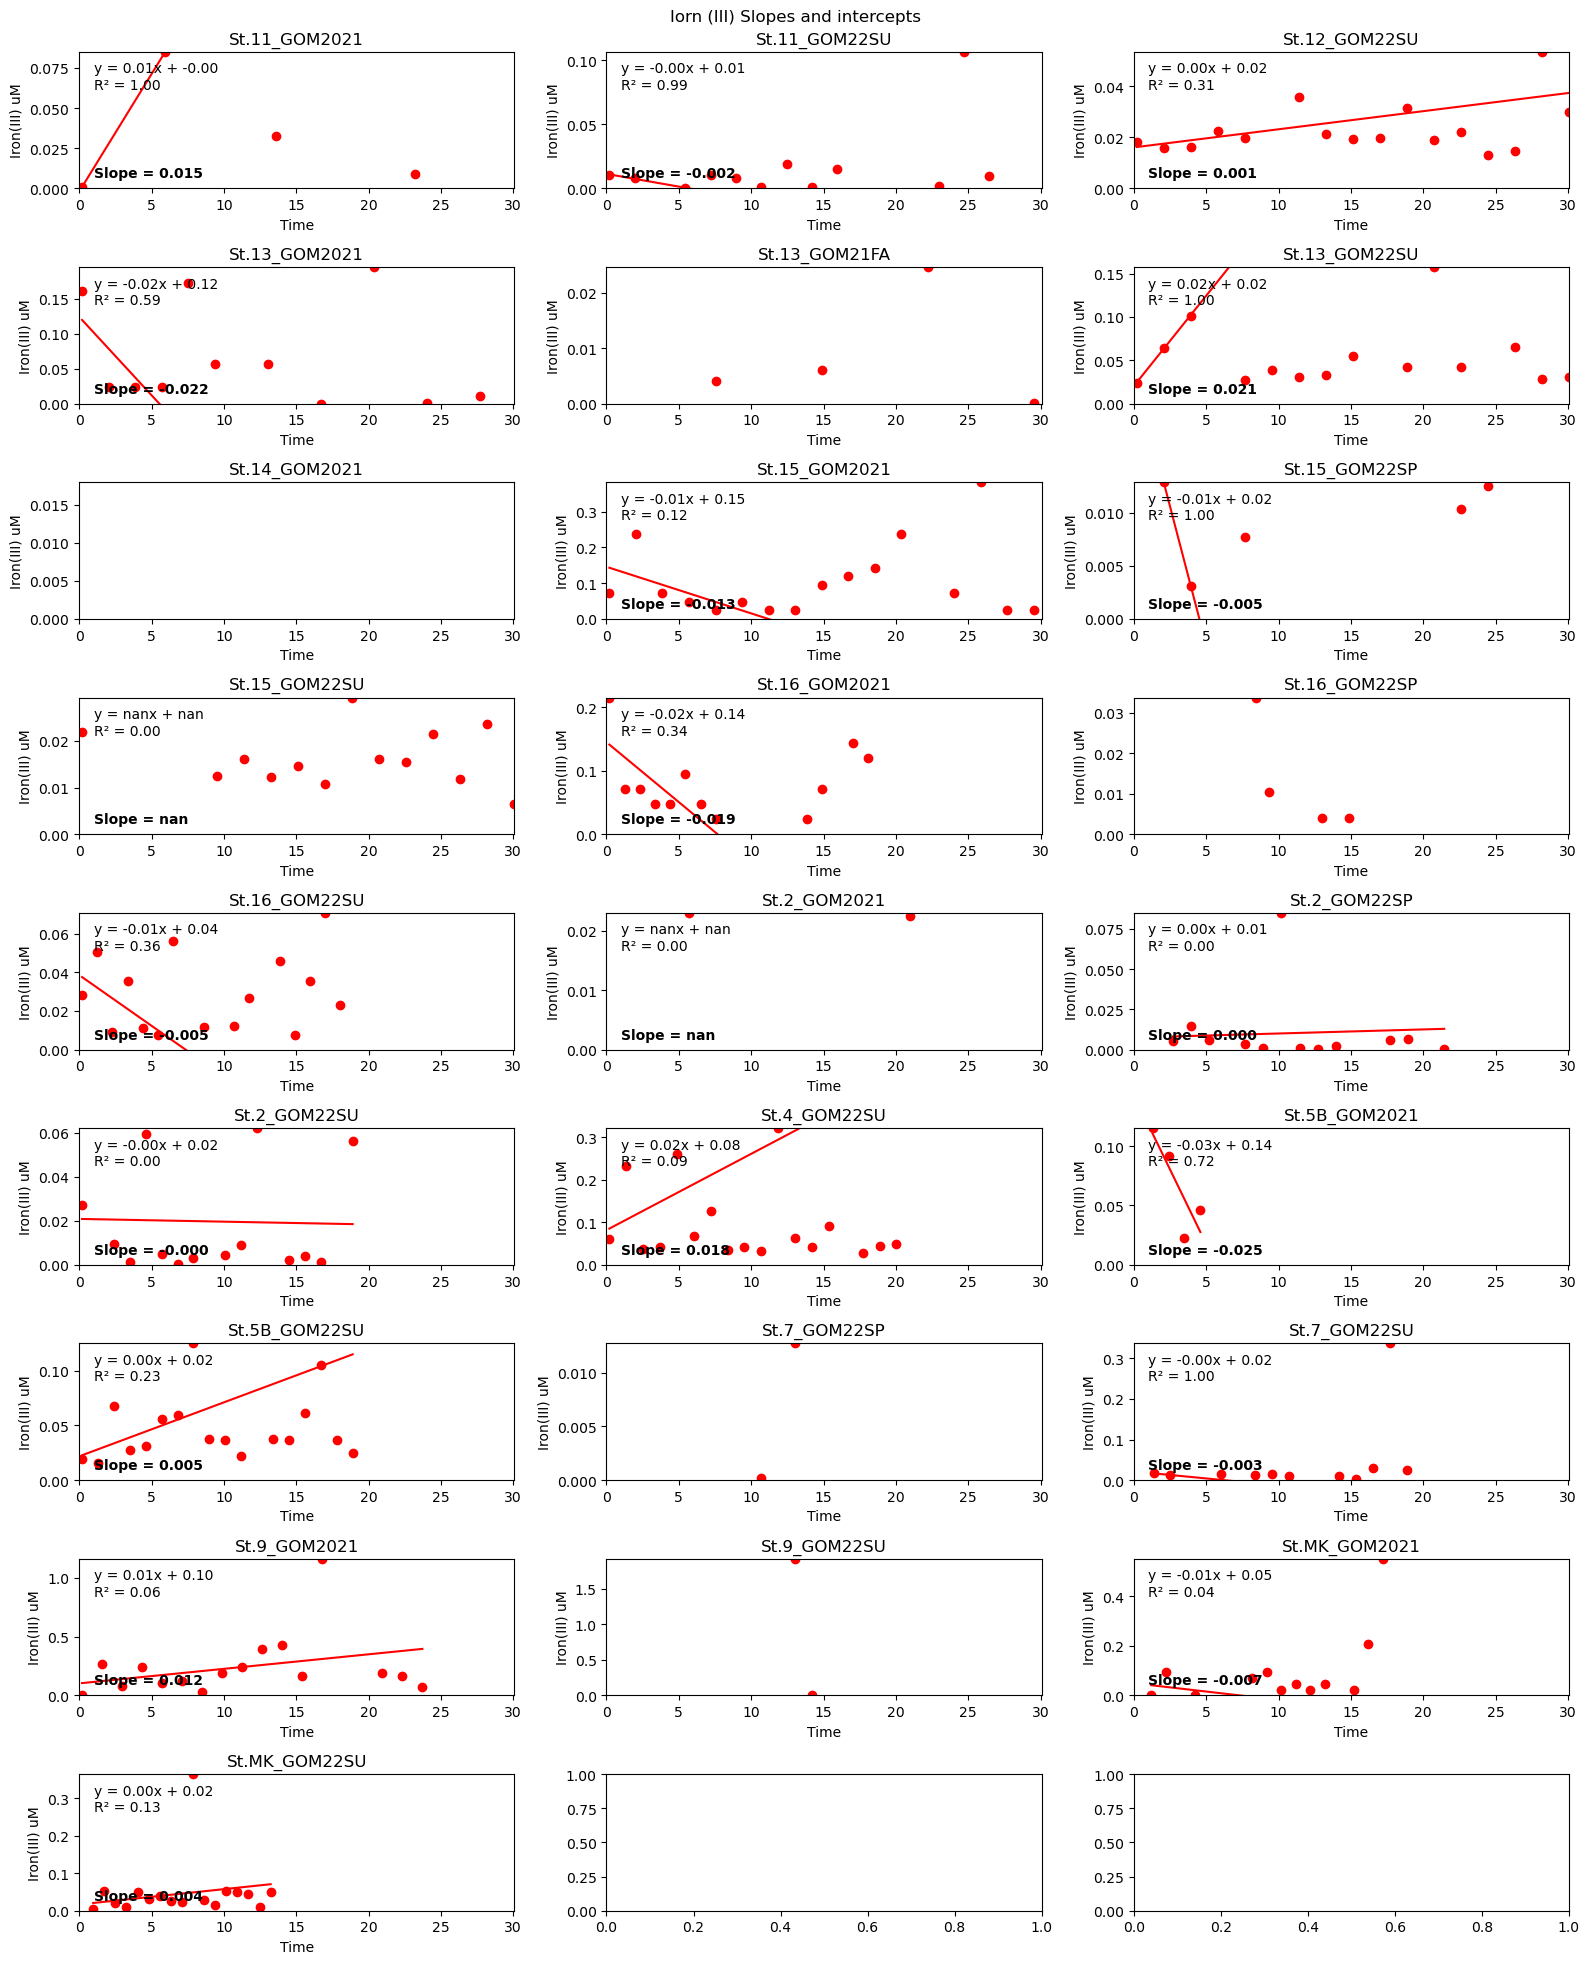

In [20]:
#Iron 3 slopes 

fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(16, 20)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe3_cl.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['FeT_Time'].ravel()
    y = group['Fe3_uM'].ravel()
    
    xx = group.loc[group['FeT_Time'] <6 , 'FeT_Time'].ravel()
    yy = group.loc[group['FeT_Time'] <6, 'Fe3_uM'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='r')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('Iron(III) uM')
    ax.set_xlim(0,df_iron_bc_fe3_cl['FeT_Time'].max())
    ax.set_ylim(0,max(y))
    
    if len(xx) > 0 and len(yy) > 0:
        # Calculate the slope of the regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)

    # Add the regression line to the plot
        ax.plot(x, intercept + slope * x, c='r')
    
    # Add the equation of the regression line to the plot
        equation = f'y = {slope:.2f}x + {intercept:.2f}'
        ax.text(1, max(y)*.85, equation)
    
    # Add the r-squared value to the plot
        rsquared = f'R² = {r_value**2:.2f}'
        ax.text(1, max(y)*.73, rsquared)
    
    # Add the slope value to the plot
        sloped = f'Slope = {slope:.3f}'
        ax.text(1, max(y)*.08, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'Iorn (III) Slopes and intercepts' '\n')
plt.tight_layout()
plt.show()

In [21]:
#Fe3 slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe3_cl.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group.loc[group['FeT_Time'] <6 , 'FeT_Time'].ravel()
    y = group.loc[group['FeT_Time'] <6, 'Fe3_uM'].ravel()    
    
    
    if len(x) > 0 and len(y) > 0:
        # Calculate the slope of the regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
        rsquared = r_value**2
    
    # Add the slope value to the plot
        slope = slope
    
        dic = {'code':[code],
               'slope_fe3':[slope],
               'rsquared_fe3':[rsquared]}
        
        slopes = pd.DataFrame(dic)
        slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_fe3 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_fe3

C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
C:\Users\hmlbr\anaconda3\envs\bugs\Lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\hmlbr\anaconda3\envs\b

slope_fe3  rsquared_fe3
code                                  
St.11_GOM2021   0.014638      1.000000
St.11_GOM22SU  -0.001984      0.988698
St.12_GOM22SU   0.000708      0.308314
St.13_GOM2021  -0.022441      0.592285
St.13_GOM2021  -0.022441      0.592285
St.13_GOM22SU   0.020826      0.999175
St.13_GOM22SU   0.020826      0.999175
St.15_GOM2021  -0.013023      0.121952
St.15_GOM22SP  -0.005221      1.000000
St.15_GOM22SU        NaN      0.000000
St.16_GOM2021  -0.018840      0.344908
St.16_GOM2021  -0.018840      0.344908
St.16_GOM22SU  -0.005257      0.357955
St.2_GOM2021         NaN      0.000000
St.2_GOM22SP    0.000253      0.003644
St.2_GOM22SU   -0.000125      0.000122
St.4_GOM22SU    0.017914      0.089705
St.5B_GOM2021  -0.025095      0.720000
St.5B_GOM22SU   0.004935      0.234274
St.5B_GOM22SU   0.004935      0.234274
St.7_GOM22SU   -0.003429      1.000000
St.9_GOM2021    0.012362      0.059589
St.9_GOM2021    0.012362      0.059589
St.MK_GOM2021  -0.006739      0.037361
St.MK_GOM22SU   0.004083      0.130506

In [22]:
#make location data 
df_lat_lon = df_meta.groupby('code').agg({'Lat': 'mean', 'Lon': 'mean'}).reset_index().set_index('code')

In [23]:
dataframes = [df_hights, df_lat_lon, slopes_a412, slopes_a350, slopes_doc, slopes_tn, slopes_fe2, slopes_fe3]
for df in dataframes:
    if not df.index.is_unique:
        print("Duplicate indices found in dataframe:", df)


Duplicate indices found in dataframe:                slope_fe2  rsquared_fe2
code                                  
St.11_GOM2021  -0.004036      1.000000
St.11_GOM22SU   0.000691      0.415760
St.12_GOM22SU   0.002304      0.936203
St.13_GOM2021   0.007384      0.300000
St.13_GOM2021   0.007384      0.300000
St.13_GOM22SU  -0.001768      0.806468
St.14_GOM21FA        NaN      0.000000
St.14_GOM22SP   0.002387      0.989305
St.14_GOM22SP   0.002387      0.989305
St.15_GOM21FA        NaN      0.000000
St.15_GOM22SP   0.004875      1.000000
St.15_GOM22SU   0.003214      0.032172
St.15_GOM22SU   0.003214      0.032172
St.16_GOM21FA  -0.001140      0.260493
St.16_GOM22SP  -0.000821      0.075855
St.16_GOM22SP  -0.000821      0.075855
St.16_GOM22SP  -0.000821      0.075855
St.2_GOM22SP   -0.000215      0.722328
St.2_GOM22SU    0.002234      0.486152
St.4_GOM2021    0.013294      1.000000
St.4_GOM2021    0.013294      1.000000
St.4_GOM2021    0.013294      1.000000
St.5B_GOM21FA  -0.002198  

In [24]:
#concat it all 
df_flux = pd.concat([df_hights, df_lat_lon, slopes_a412, slopes_a350, 
                     slopes_doc, slopes_tn], axis=1, join='outer')

#calcute flux 
df_flux["flux_aCDOM412"] = df_flux["slope_a412"] * df_flux["Hight_m"] *24
df_flux["flux_aCDOM350"] = df_flux["slope_a350"] * df_flux["Hight_m"] *24
df_flux["flux_doc"] = df_flux["slope_doc"] * df_flux["Hight_m"] *24
df_flux["flux_tn"] = df_flux["slope_tn"] * df_flux["Hight_m"] *24
#df_flux["flux_fe2"] = df_flux["slope_fe2"] * df_flux["Hight_m"] *24
#df_flux["flux_fe3"] = df_flux["slope_fe3"] * df_flux["Hight_m"] *24

df_flux

Camp    Stn   Hight_m        Lat        Lon  slope_a412  \
code                                                                          
St.4_GOM22SU     GOM22SU   St.4  0.042412  28.793151 -90.697399    0.036592   
St.5B_GOM22SU    GOM22SU  St.5B  0.045239  28.797889 -91.322172    0.467911   
St.7_GOM22SU     GOM22SU   St.7  0.040527  28.909318 -89.856156   -0.008227   
St.9_GOM22SU     GOM22SU   St.9  0.030536  28.786307 -89.598689   -0.230440   
St.14_GOM22SU    GOM22SU  St.14  0.032987  28.728776 -89.620647    0.014624   
St.15_GOM22SU    GOM22SU  St.15  0.034118  28.950645 -88.842176    0.009605   
St.13_GOM22SU    GOM22SU  St.13  0.030159  28.524547 -89.597871   -0.033504   
St.2_GOM22SU     GOM22SU   St.2  0.027921  28.896161 -89.585844    1.834835   
St.16_GOM22SU    GOM22SU  St.16  0.028746  28.891260 -89.536424   -0.015287   
St.12_GOM22SU    GOM22SU  St.12  0.044296  28.593063 -88.878258    0.125514   
St.11_GOM22SU    GOM22SU  St.11  0.038170  28.202880 -89.581503    0.073135   
St.MK_GOM22SU    GOM22SU  St.MK  0.053721  28.903147 -90.301611    0.028309   
St.7_GOM2021     GOM2021   St.7  0.067500  28.918272 -89.875616    0.005769   
St.2_GOM2021     GOM2021   St.2  0.115000  28.899542 -89.593172    0.025588   
St.11_GOM2021    GOM2021  St.11  0.176667  28.225724 -89.540904    0.005215   
St.13_GOM2021    GOM2021  St.13  0.070000  28.536039 -89.492085    0.016707   
St.5B_GOM2021    GOM2021  St.5B  0.158750  28.811667 -91.343178   -0.019317   
St.MK_GOM2021    GOM2021  St.MK  0.201250  28.906549 -90.334712    0.036555   
St.4_GOM2021     GOM2021   St.4  0.163500  28.799256 -90.711336         NaN   
St.9_GOM2021     GOM2021   St.9  0.071250  28.799761 -89.598594   -0.012174   
St.16_GOM2021    GOM2021  St.16  0.126667  28.876302 -89.547035   -0.006845   
St.15_GOM2021    GOM2021  St.15  0.118333  28.942528 -88.835023   -0.001049   
St.5B_GOM22SP    GOM22SP  St.5B  0.168750  28.808891 -91.338694    0.021206   
St.7_GOM22SP     GOM22SP   St.7  0.146667  28.917214 -89.859921    0.000903   
St.9_GOM22SP     GOM22SP   St.9  0.162500  28.787287 -89.607676    0.003948   
St.14_GOM22SP    GOM22SP  St.14  0.140000  28.726195 -89.613151   -0.002697   
St.13_GOM22SP    GOM22SP  St.13  0.145000  28.507026 -89.622720         NaN   
St.15_GOM22SP    GOM22SP  St.15  0.103333  28.944296 -88.860281   -0.004065   
St.16_GOM22SP    GOM22SP  St.16  0.180000  28.914785 -89.545059   -0.004262   
St.MK_GOM22SP    GOM22SP  St.MK  0.136667  28.902410 -90.309229         NaN   
St.2_GOM22SP     GOM22SP   St.2  0.088750  28.899786 -89.605333    0.004888   
St.4_GOM22SP     GOM22SP   St.4  0.180000  28.798798 -90.706620   -0.008073   
St.5B_GOM21FA    GOM21FA  St.5B  0.116667  28.806169 -91.335944    0.022647   
St.4_GOM21FA     GOM21FA   St.4       NaN  28.795872 -90.702649         NaN   
St.MK_GOM21FA    GOM21FA  St.MK  0.217500  28.913659 -90.328519    0.012664   
St.7_GOM21FA     GOM21FA   St.7  0.170000  28.910991 -89.872204   -0.024455   
St.14_GOM21FA    GOM21FA  St.14  0.158333  28.727625 -89.620568   -0.008956   
St.9_GOM21FA     GOM21FA   St.9  0.115000  28.782994 -89.599750    0.035855   
St.15_GOM21FA    GOM21FA  St.15  0.140000  28.950023 -88.846716    0.014926   
St.2_GOM21FA     GOM21FA   St.2       NaN  28.895167 -89.604095         NaN   
St.13_GOM21FA    GOM21FA  St.13  0.133333  28.524193 -89.610854   -0.007752   
St.12_GOM21FA    GOM21FA  St.12  0.145000  28.594249 -88.903741    0.020387   
St.11_GOM21FA    GOM21FA  St.11  0.233333  28.209529 -89.591672    0.004109   
St.16_GOM21FA    GOM21FA  St.16  0.133333  28.885048 -89.542132   -0.003061   
St.14.5_GOM21FA      NaN    NaN       NaN  28.839288 -89.240600         NaN   
St.14_GOM2021        NaN    NaN       NaN  28.726863 -89.601437         NaN   
St.16-2_GOM21FA      NaN    NaN       NaN  28.981827 -89.466488         NaN   
St.6_GOM21FA         NaN    NaN       NaN  29.101076 -92.197066         NaN   
St.9 _GOM22SU        NaN    NaN       NaN        NaN        NaN       

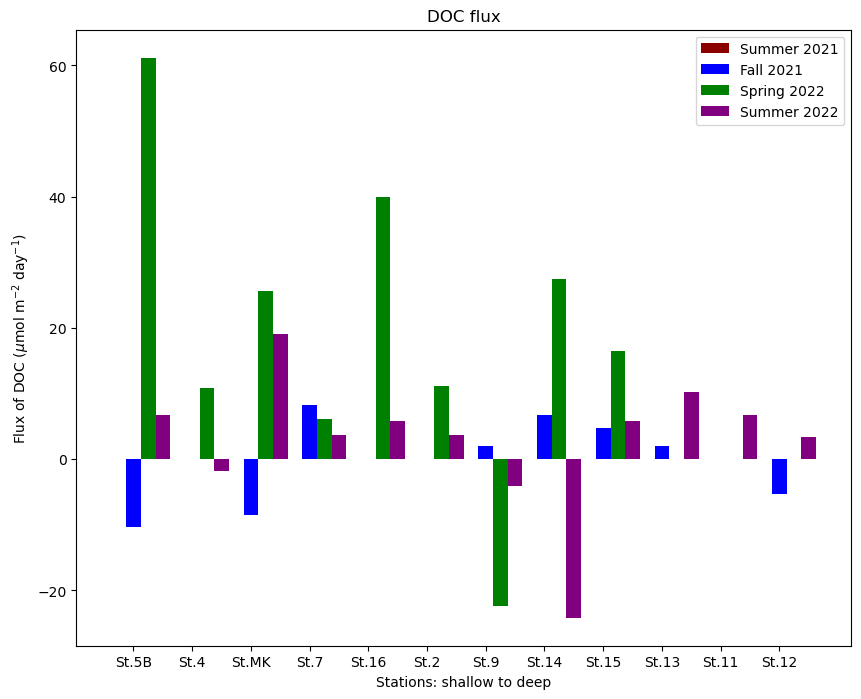

In [25]:
# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_doc"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

fig, axs = plt.subplots(figsize=(10, 8)) 

# Set position of bars on x axis
r = np.arange(len(categories))
positions = [r + i*barWidth for i in range(len(subcategories))]

all_bars = []

for pos, subcat in zip(positions, subcategories):
    values = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['Camp'] == subcat)]['flux_doc'].values
        values.append(value[0] if len(value) > 0 else 0)
    bars = plt.bar(pos, values, width=barWidth, color=color_map[subcat], label=label_map[subcat])
    all_bars.append(bars)
    
plt.legend()

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
plt.legend(handles[:len(subcategories)], labels)

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('Stations: shallow to deep')
plt.ylabel(r'Flux of DOC ($\mu$mol m$^{-2}$ day$^{-1}$)')
plt.title('DOC flux')
plt.xticks(r + barWidth, categories)

plt.legend()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/DOC_flux_barplot.png")

plt.show()

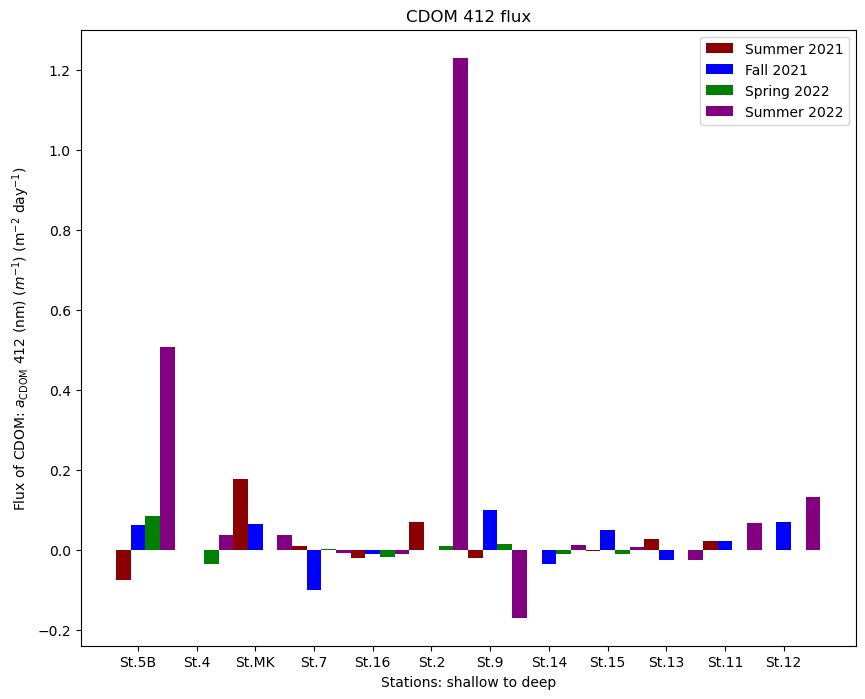

In [26]:
# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_aCDOM412"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

fig, axs = plt.subplots(figsize=(10, 8)) 

# Set position of bars on x axis
r = np.arange(len(categories))
positions = [r + i*barWidth for i in range(len(subcategories))]

all_bars = []

for pos, subcat in zip(positions, subcategories):
    values = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['Camp'] == subcat)]['flux_aCDOM412'].values
        values.append(value[0] if len(value) > 0 else 0)
    bars = plt.bar(pos, values, width=barWidth, color=color_map[subcat], label=label_map[subcat])
    all_bars.append(bars)
    
plt.legend()

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
plt.legend(handles[:len(subcategories)], labels)

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('Stations: shallow to deep')
plt.ylabel(r'Flux of CDOM: $a_{\mathrm{CDOM}}$ 412 (nm) $(m^{-1})$ (m$^{-2}$ day$^{-1}$)')
plt.title('CDOM 412 flux')
plt.xticks(r + barWidth, categories)

plt.legend()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM412_flux_barplot.png")

plt.show()

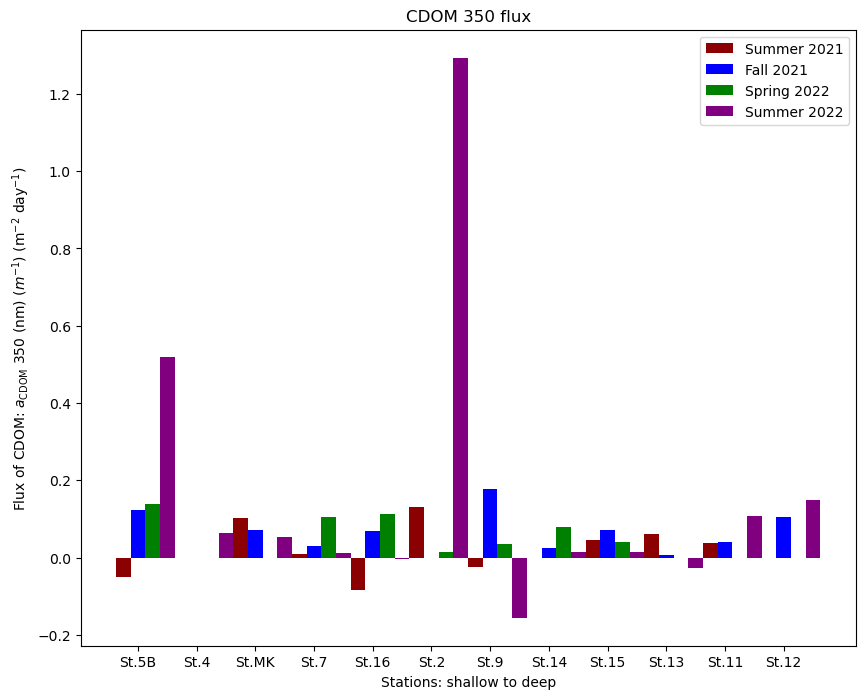

In [27]:
# Unique categories and subcategories
df = df_flux.dropna(subset=["flux_aCDOM350"])

categories = ['St.5B','St.4','St.MK','St.7','St.16','St.2','St.9','St.14','St.15','St.13','St.11','St.12']
subcategories = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Define custom colors
color_map = {
    'GOM2021': 'darkred',
    'GOM21FA': 'blue',
    'GOM22SP': 'green',
    'GOM22SU': 'purple'
}

# Define custom labels (if they differ from subcategory names)
label_map = {
    'GOM2021': 'Summer 2021',
    'GOM21FA': 'Fall 2021',
    'GOM22SP': 'Spring 2022',
    'GOM22SU': 'Summer 2022'
}

barWidth = 0.25

fig, axs = plt.subplots(figsize=(10, 8)) 

# Set position of bars on x axis
r = np.arange(len(categories))
positions = [r + i*barWidth for i in range(len(subcategories))]

all_bars = []

for pos, subcat in zip(positions, subcategories):
    values = []
    for cat in categories:
        value = df[(df['Stn'] == cat) & (df['Camp'] == subcat)]['flux_aCDOM350'].values
        values.append(value[0] if len(value) > 0 else 0)
    bars = plt.bar(pos, values, width=barWidth, color=color_map[subcat], label=label_map[subcat])
    all_bars.append(bars)
    
plt.legend()

handles, _ = plt.gca().get_legend_handles_labels()
labels = [label_map[subcat] for subcat in subcategories]
plt.legend(handles[:len(subcategories)], labels)

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('Stations: shallow to deep')
plt.ylabel(r'Flux of CDOM: $a_{\mathrm{CDOM}}$ 350 (nm) $(m^{-1})$ (m$^{-2}$ day$^{-1}$)')
plt.title('CDOM 350 flux')
plt.xticks(r + barWidth, categories)

plt.legend()
fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/CDOM350_flux_barplot.png")

plt.show()

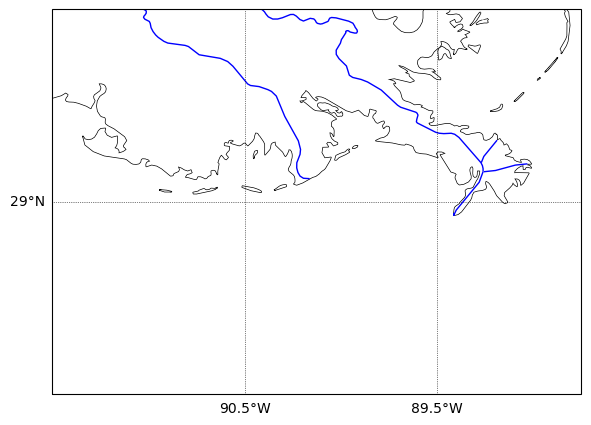

In [28]:
lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# set resolution of the features in map: '10m', '50m', or '110m'.  
# If you do this the first time it will take a while downloading the coastline 
# and other features. In the future it will be faster
res = '10m'

#Figure


def plot_mapbase(extent, res='10m', projection=ccrs.PlateCarree()):
    fig = plt.figure(figsize=(10,5)) # set fig size
    ax = fig.add_subplot(111, projection=projection)
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', # change color here
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue', # change color here
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = plot_mapbase(extent)


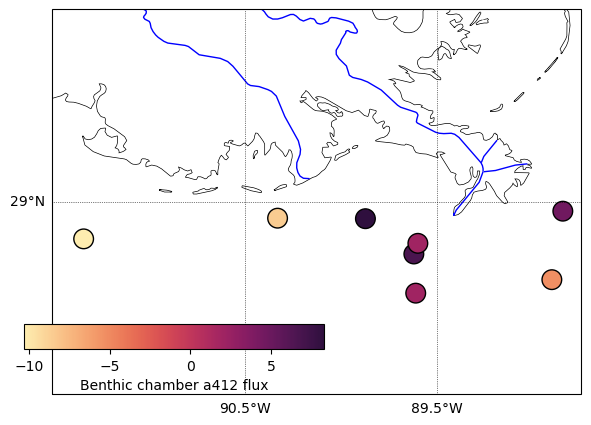

In [29]:
df = df_flux.dropna(subset=["flux_doc"])
df = df[df['Camp'] == 'GOM21FA']

fig, ax = plot_mapbase(extent)
mappable = ax.scatter(df['Lon'], df['Lat'],
                      c = df['flux_doc'],           
                      edgecolor='k',  #you color variable
                      cmap= cmo.matter, # colormap. look for other colormaps https://matplotlib.org/stable/tutorials/colors/colormaps.html
                      s=200, # your size variable. Can get rid if don't need
                      transform=ccrs.PlateCarree())
cax = fig.add_axes([.22, .2, .3, .05])
cb2 = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb2.set_label('Benthic chamber a412 flux', size=10, color='black')
cb2.ax.tick_params(labelcolor='black') 
cb2.ax.tick_params(labelsize=10)

fig.set_facecolor('w')



#fig.savefig('../MAPS_Figures/BC_flux_412.png')

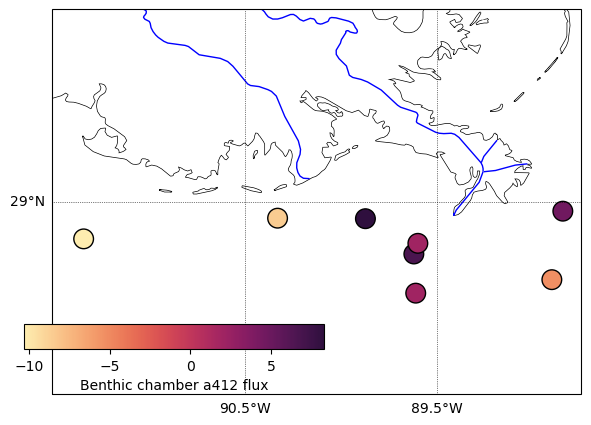

In [30]:
df = df_flux.dropna(subset=["flux_doc"])
df = df[df['Camp'] == 'GOM21FA']

fig, ax = plot_mapbase(extent)
mappable = ax.scatter(df['Lon'], df['Lat'],
                      c = df['flux_doc'],           
                      edgecolor='k',  #you color variable
                      cmap= cmo.matter, # colormap. look for other colormaps https://matplotlib.org/stable/tutorials/colors/colormaps.html
                      s=200, # your size variable. Can get rid if don't need
                      transform=ccrs.PlateCarree())
cax = fig.add_axes([.22, .2, .3, .05])
cb2 = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb2.set_label('Benthic chamber a412 flux', size=10, color='black')
cb2.ax.tick_params(labelcolor='black') 
cb2.ax.tick_params(labelsize=10)

fig.set_facecolor('w')

In [31]:
def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='white', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax


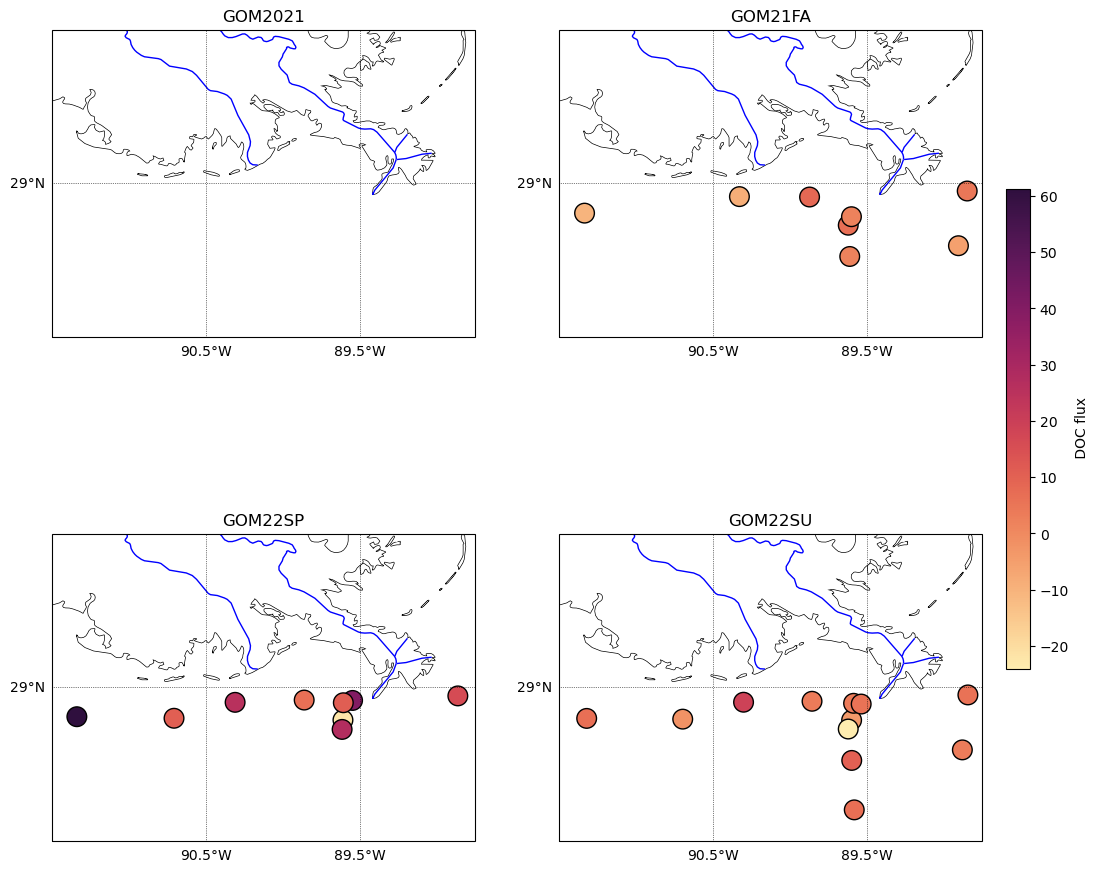

In [32]:
# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Find global min and max for the colormap
vmin = df_flux['flux_doc'].min()
vmax = df_flux['flux_doc'].max()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index

for i, camp in enumerate(camps):
    df_subset = df_flux[df_flux['Camp'] == camp].dropna(subset=["flux_doc"])
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                               c=df_subset['flux_doc'],
                               edgecolor='k',
                               cmap=cmo.matter,
                               s=200,
                               vmin=vmin,  # Set global min and max for colormap
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label(' DOC flux', size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Map_DOC_Flux.png")

plt.show()


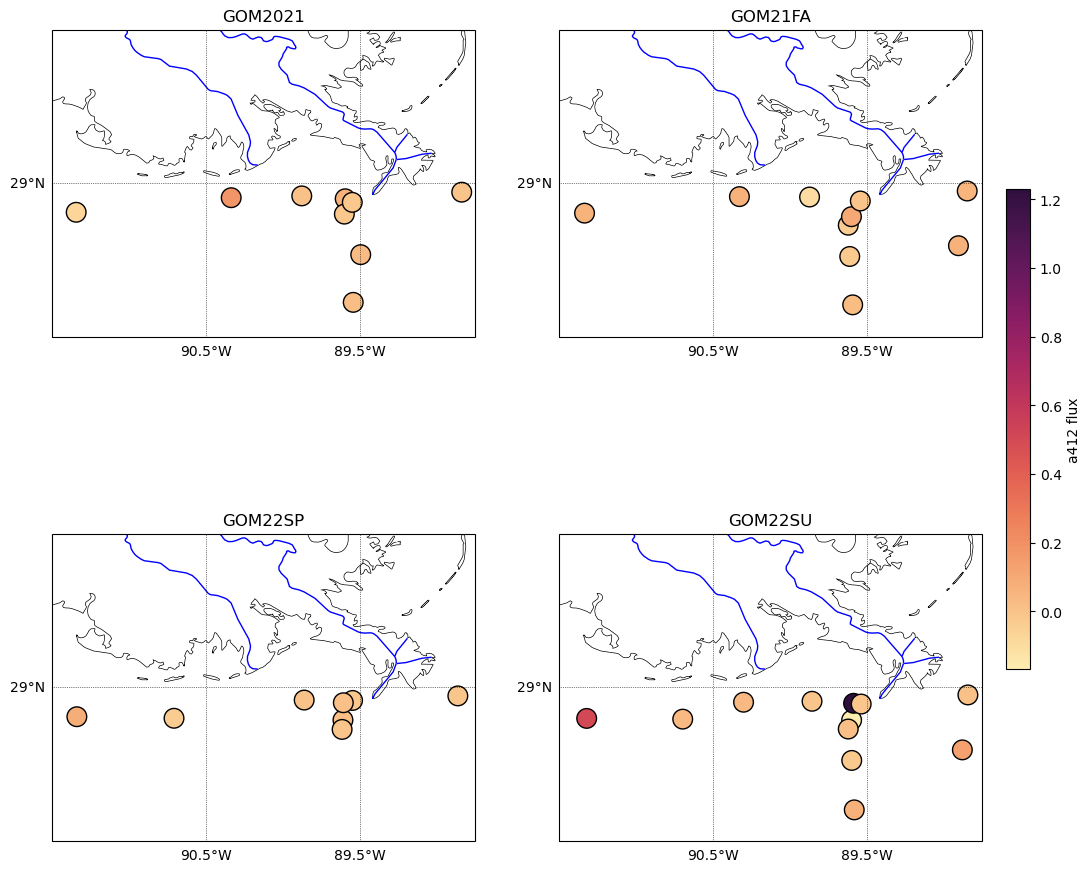

In [33]:
# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Find global min and max for the colormap
vmin = df_flux['flux_aCDOM412'].min()
vmax = df_flux['flux_aCDOM412'].max()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index

for i, camp in enumerate(camps):
    df_subset = df_flux[df_flux['Camp'] == camp].dropna(subset=["flux_aCDOM412"])
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                               c=df_subset['flux_aCDOM412'],
                               edgecolor='k',
                               cmap=cmo.matter,
                               s=200,
                               vmin=vmin,  # Set global min and max for colormap
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label('a412 flux', size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Map_CDOM412_Flux.png")

plt.show()


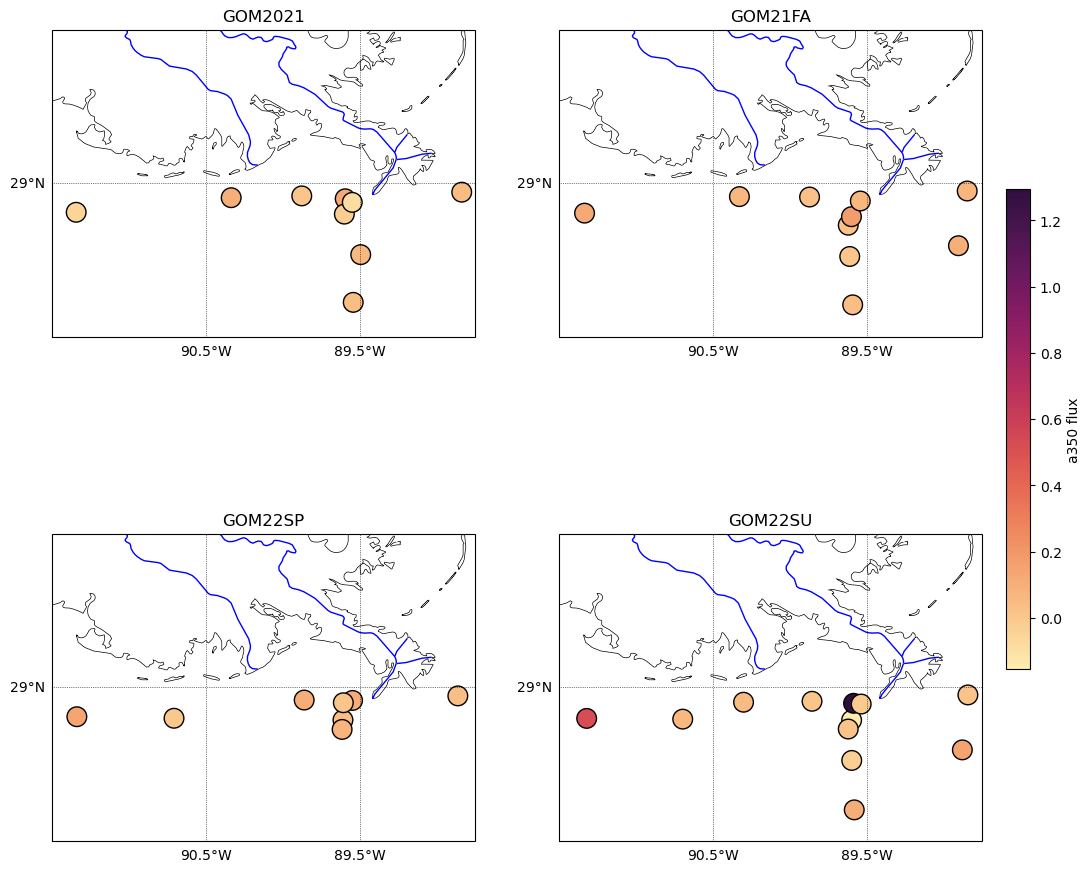

In [34]:
# List of unique Camp values you want to plot
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

# Find global min and max for the colormap
vmin = df_flux['flux_aCDOM350'].min()
vmax = df_flux['flux_aCDOM350'].max()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index

for i, camp in enumerate(camps):
    df_subset = df_flux[df_flux['Camp'] == camp].dropna(subset=["flux_aCDOM350"])
    
    # Plot the base map for each subplot
    plot_mapbase(extent, ax=axes[i])
    
    # Plotting
    mappable = axes[i].scatter(df_subset['Lon'], df_subset['Lat'],
                               c=df_subset['flux_aCDOM350'],
                               edgecolor='k',
                               cmap=cmo.matter,
                               s=200,
                               vmin=vmin,  # Set global min and max for colormap
                               vmax=vmax,
                               transform=ccrs.PlateCarree())
    
    # Set title for each subplot
    axes[i].set_title(camp)
    
# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cb = fig.colorbar(mappable, cax=cbar_ax)
cb.set_label('a350 flux', size=10, color='black')
cb.ax.tick_params(labelcolor='black') 
cb.ax.tick_params(labelsize=10)

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Map_CDOM350_Flux.png")

plt.show()


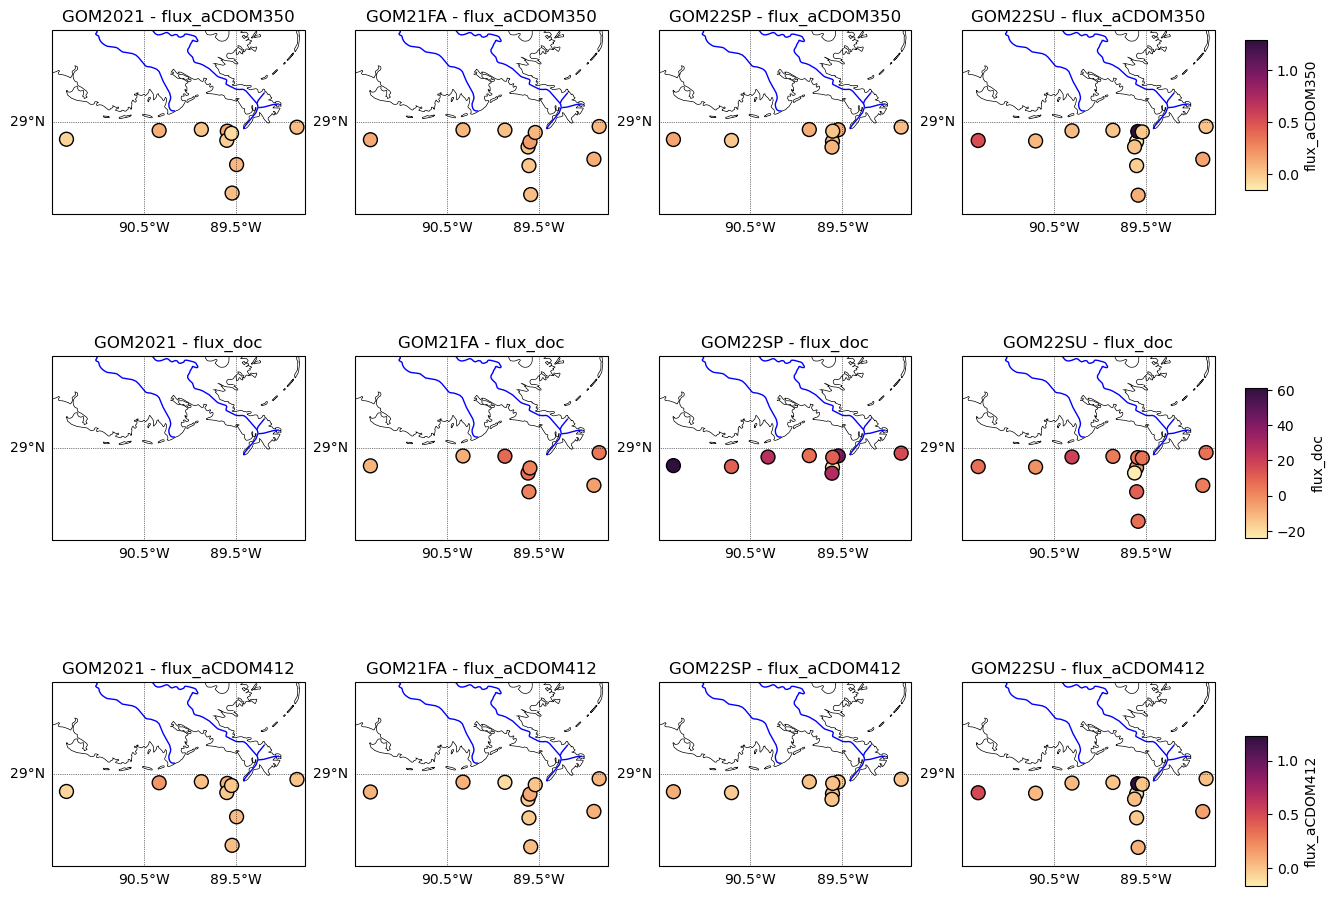

In [35]:
# Define the camps and flux types
camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
flux_types = ['flux_aCDOM350', 'flux_doc', 'flux_aCDOM412']

# Create a 3x4 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})

for row, flux_type in enumerate(flux_types):
    # Determine the global min and max for the current flux type across all camps
    vmin = df_flux[df_flux['Camp'].isin(camps)][flux_type].min()
    vmax = df_flux[df_flux['Camp'].isin(camps)][flux_type].max()
    
    for col, camp in enumerate(camps):
        df_subset = df_flux[df_flux['Camp'] == camp].dropna(subset=[flux_type])
        
        mappable = axes[row, col].scatter(df_subset['Lon'], df_subset['Lat'],
                                          c=df_subset[flux_type],
                                          edgecolor='k',
                                          cmap=cmo.matter,
                                          s=100,
                                          vmin=vmin,
                                          vmax=vmax,
                                          transform=ccrs.PlateCarree())
        
        axes[row, col].set_title(f'{camp} - {flux_type}')
        
        plot_mapbase(extent, ax=axes[row, col])

    # Add a colorbar for each row (flux type)
    cbar_ax = fig.add_axes([0.92, 1-(0.29*(row+1)), 0.015, 0.125])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(flux_type, size=10, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)

fig.set_facecolor('w')

plt.savefig("../Dissertation_projects/Figures/Flux_figures/Maps_Flux.png")

plt.show()
